<center><h1> Análisis sobre funcionarios públicos municipales.</h1></center>

La idea es realizar un análisis rapido sobre funcionarios municipales (particularmente sueldos y género). Utilizamos los datos que figuran en el portal de datos abiertos del gobierno municipal ([datos](https://gobiernoabierto.cordoba.gob.ar/data/datos-abiertos/categoria/funcionarios/sueldo-de-funcionarios/131)), bajo el titulo  *Sueldo de funcionarios*.

* <a class="buttom" href="#los_datos">Datos: Descarga</a> <br>
* <a class="buttom" href="#curado">Datos: Pre-Procesamiento</a> <br>
* <a class="buttom" href="#analisis">Datos: Análisis</a> <br>
    - <a class="buttom" href="#genero">Datos: Género</a> <br>
    - <a class="buttom" href="#genero_sueldo">Datos: Género y Sueldo</a> <br>
    - <a class="buttom" href="#genero_sueldo_dni">Datos: Género - Sueldo - Distribución de edades</a> <br>

El procesamiento depende de las librerias:

In [1]:
# libs
## gen
import os
import glob as glb
## num
import numpy as np
import pandas as pd
## viz
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

<a id='los_datos'></a>

## Datos: Descarga

Al momento de realizar al análisis los salarios de los funcionarios parecen haberse cargado desde abril del 2016 hasta octubre del 2018. 

In [2]:
# https://gobiernoabierto.cordoba.gob.ar/data/datos-abiertos/categoria/funcionarios/sueldo-de-funcionarios/131
base_url="https://gobiernoabierto.cordoba.gob.ar/datos/sueldos"
#Los salarios parecen haberse cargado desde abril del 2016 hasta octubre del 2018 
#en la forma base_url/sueldos-año-mes.csv
# Armamos el date range e iteramos para armar las url
range_date=pd.date_range(start='4/1/2016', end='11/1/2018',freq='M')
#
f2d=[]
for ym in range_date:
    year,month= '{0:d}'.format(ym.year),'{0:02d}'.format(ym.month)
    pathf=os.path.join(base_url,'sueldos-'+year+'-'+month+'.csv')
    f2d.append(pathf)

# Descargamos la info 
# Si dw==True
dw=False
if dw:
    for f in f2d:
        !wget  $f
    if not os.path.isdir('data'):
        os.mkdir('data')
        print('Se creo el directorio "data"')
    !cp *.csv 'data'
    !rm *.csv
if not os.path.isdir('img'):
    os.mkdir('img')
    print('Se creo el directorio "img"')
# Veamos que obtuvimos
csv_list=glb.glob('data/*.csv'); csv_list.sort()
print('#######################################################')
print('##################### ARCHIVOS ########################')
print('Se obtuvieron un total de {} archivos'.format(len(csv_list)))

#######################################################
##################### ARCHIVOS ########################
Se obtuvieron un total de 31 archivos


<a id='curado'></a>

## Pre-Procesamiento

### Unimos los DataFrames

Unimos los data frames y nos fijamos faltantes.

csv sin data: data/sueldos-2016-09.csv - index: 5 @ lst_len
csv sin data: data/sueldos-2017-12.csv - index: 20 @ lst_len
csv sin data: data/sueldos-2018-08.csv - index: 28 @ lst_len


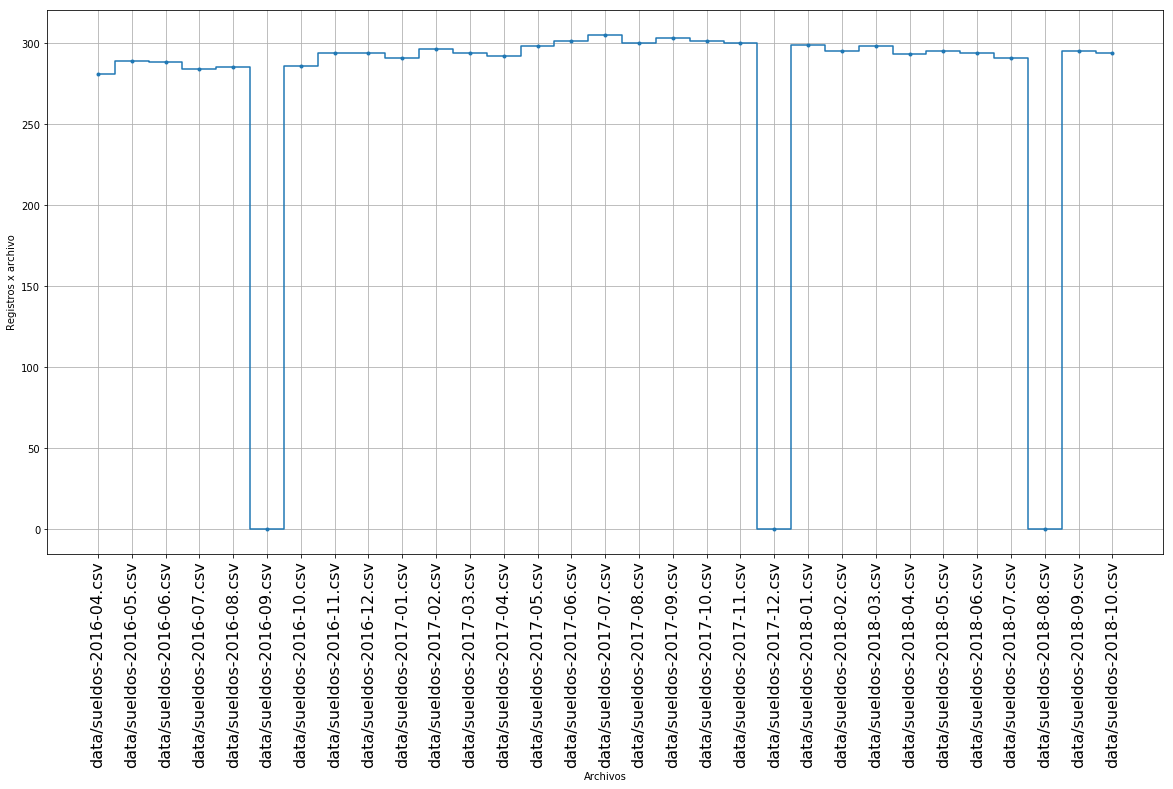

In [3]:
pd_list = []; lst_len = []
for ic,c in enumerate(csv_list):
    pd_tempi=pd.read_csv(c,parse_dates=[4],dayfirst=True)
    lst_len.append([ic,c,len(pd_tempi)])
    pd_list.append(pd_tempi)
pd_cat_raw=pd.concat(pd_list,axis=0)
# Veamos si tenemos datos en todos los casos
for i,n,l in lst_len:
    if l==0:
        print('csv sin data: {} - index: {} @ lst_len'.format(n,i))
#
#
pd_len=pd.DataFrame(lst_len,columns=['idx','nombre','cantidad_registros'])
fig,ax=plt.subplots(1,1,figsize=(20,10))
ax.step(pd_len['nombre'],pd_len['cantidad_registros'],'.-',where='mid')
ax.set_xticklabels(pd_len['nombre'],rotation=90,fontsize=16);
ax.set_ylabel('Registros x archivo')
ax.set_xlabel('Archivos');
ax.grid(True)

Observamos que tenemos tres csv sin datos (quizas algun defecto en la carga o similar).

In [4]:
pd_len

,idx,nombre,cantidad_registros
0,0,data/sueldos-2016-04.csv,281
1,1,data/sueldos-2016-05.csv,289
2,2,data/sueldos-2016-06.csv,288
3,3,data/sueldos-2016-07.csv,284
4,4,data/sueldos-2016-08.csv,285
5,5,data/sueldos-2016-09.csv,0
6,6,data/sueldos-2016-10.csv,286
7,7,data/sueldos-2016-11.csv,294
8,8,data/sueldos-2016-12.csv,294
9,9,data/sueldos-2017-01.csv,291


Eliminamos la información no necesaria y generamos características extras.

In [5]:
# Veamos las columnas presentes
pd_cat_raw.columns

Index(['Nombre', 'Apellido', 'Genero', 'DOC', 'Mes', 'Moneda', 'Sueldo Bruto',
       'Sueldo Neto'],
      dtype='object')

In [6]:
# Particularmente no nos interesan nombres ni apellidos
pd_cat_raw.drop(columns=['Nombre','Apellido'],inplace=True)
#
# Veamos dist por DNI
pd_cat_raw['DOC_TYPE']=pd_cat_raw.DOC.apply(lambda x: x.split()[0]) #Tipo DNI
pd_cat_raw['DOC_EMS']=pd_cat_raw.DOC.apply(lambda x: x.split()[1]) # EMISOR
pd_cat_raw['DOC_NUM']=pd_cat_raw.DOC.apply(lambda x: x.split()[2]).astype(int) # NUMERO

Los que tenemos basicamente son datos indexados temporalmente. En una inspección preliminar se puede ver que existen algunos pagos desglosados (Mismo DOC, Mismo Mes, distintos Sueldos).
Para este situación en casos de conteo, vamos a unificar la información sumando los ingresos para el mismo Mes.

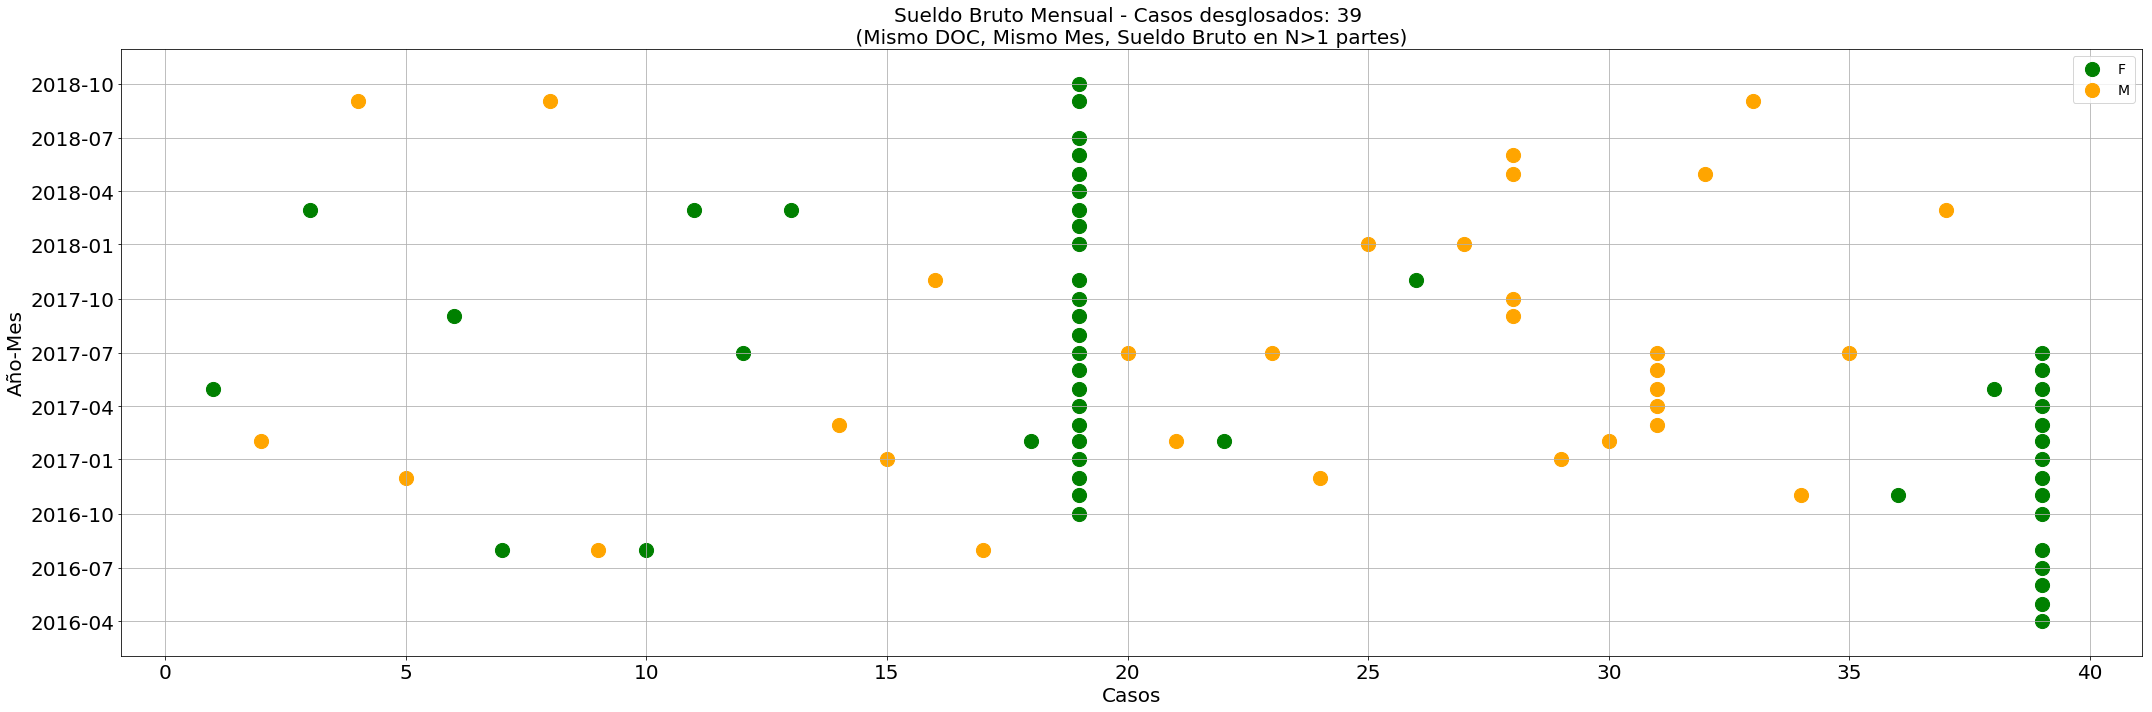

In [7]:
tmp=pd_cat_raw[pd_cat_raw.duplicated(subset=['DOC','Mes'],keep=False)].groupby(by=['Mes','DOC_NUM']).sum().unstack('DOC_NUM')['Sueldo Bruto']
f,ax=plt.subplots(1,1,figsize=(30,10))
for i,c in enumerate(tmp.columns,start=1):
    y=tmp[c]
    color='orange'
    if pd_cat_raw[pd_cat_raw.DOC_NUM==c]['Genero'].iloc[0]=='F':
        color='green'
    y[y.notna()]=i
    ax.scatter(y=tmp.index,x=y,s=200,marker='o',c=color)
ax.grid(True,which='major',axis='both')
ax.set_title('Sueldo Bruto Mensual - Casos desglosados: {} \n (Mismo DOC, Mismo Mes, Sueldo Bruto en N>1 partes) '.format(i),fontsize=20)
ax.set_ylabel('Año-Mes',fontsize=20)
ax.set_xlabel('Casos',fontsize=20)
ax.tick_params(axis='both',labelsize=20)
ax.legend(['F','M'],fontsize=14)
plt.tight_layout()
plt.savefig('img/sueldoN_casos_desglosados.png')

Cada caso corresponde a una persona cuyo sueldo fue desdoblado. En general se observan en instancias unicas y sin recurrencia  con la salvedad de un par de casos.

En lo que sigue vamos desechar los casos duplicados (pero sumar los ingresos correspondientemente).

In [8]:
#Tenemos en total
s_raw=len(pd_cat_raw)
idx2drop=pd_cat_raw[pd_cat_raw.duplicated(subset=['DOC','Mes'],keep='last')].index
casosef2rem=pd_cat_raw[pd_cat_raw.duplicated(subset=['DOC','Mes'],keep='last')].groupby(by=['Mes','DOC_NUM']).sum().reset_index().shape[0]
s_dup=len(idx2drop)
print('Casos sin reduccion: {}'.format(s_raw))
print('Cantidad de indices a reducir: {}'.format(s_dup))
print('Cantidad casos a reducir: {}'.format(casosef2rem))
print('Casos esperados despues del merge: {}'.format(s_raw-s_dup))

Casos sin reduccion: 8236
Cantidad de indices a reducir: 84
Cantidad casos a reducir: 82
Casos esperados despues del merge: 8152


In [9]:
# La diferencia entre los indices y los casos a reducir se entiende en que existe al menos un caso que tiene mas de dos instancias para DOC y Mes
# Esto lo vemos por ejemplo en:
pd_cat_raw[pd_cat_raw.duplicated(subset=['DOC','Mes'],keep=False)].groupby(by=['Mes','DOC']).count().sort_values('DOC_NUM')['DOC_NUM'].reset_index().tail()

,Mes,DOC,DOC_NUM
77,2017-02-01,DNI (AR) 10542872,2
78,2017-01-01,DNI (AR) 93750854,2
79,2017-02-01,DNI (AR) 93750854,2
80,2018-10-01,DNI (AR) 23089585,2
81,2017-07-01,DNI (AR) 26567447,4


In [10]:
# Entendido esto vamos por la reduccion
# Veamos primero el set general
pd_cat_0=pd_cat_raw.drop_duplicates(subset=['DOC','Mes'],keep='first').copy()
print(pd_cat_0.shape)

(8152, 9)


In [11]:
#Veamos el set de duplicados
pd_cat_1=pd_cat_raw[pd_cat_raw.duplicated(subset=['DOC','Mes'],keep=False)].groupby(by=['Mes','DOC_NUM']).sum().reset_index().copy()
print(pd_cat_1.shape)
pd_cat_1.head()

(82, 4)


,Mes,DOC_NUM,Sueldo Bruto,Sueldo Neto
0,2016-04-01,93750854,80361.8,52685.79
1,2016-05-01,93750854,86790.8,57201.23
2,2016-06-01,93750854,130186.2,89816.13
3,2016-07-01,93750854,86790.8,58964.60
4,2016-08-01,14366857,55719.5,34607.45


In [12]:
# Vamos a hacer el merge usando Mes y DOC_NUM como keys y pisamos Sueldo Bruto y Sueldo Neto
pd_cat_int=pd.merge(pd_cat_0,pd_cat_1,how='outer',on=['Mes','DOC_NUM'],suffixes=('','_1'))
bool_flag=pd_cat_int['Sueldo Bruto_1'].notna();
pd_cat_int.loc[bool_flag,'Sueldo Bruto']=pd_cat_int[bool_flag]['Sueldo Bruto_1']
pd_cat_int.loc[bool_flag,'Sueldo Neto']=pd_cat_int[bool_flag]['Sueldo Neto_1']
#
pd_cat=pd_cat_int.copy()
pd_cat.drop(columns=['Sueldo Bruto_1','Sueldo Neto_1'],inplace=True)
pd_cat[pd_cat.isna()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8152 entries, 0 to 8151
Data columns (total 9 columns):
Genero          0 non-null object
DOC             0 non-null object
Mes             0 non-null datetime64[ns]
Moneda          0 non-null object
Sueldo Bruto    0 non-null float64
Sueldo Neto     0 non-null float64
DOC_TYPE        0 non-null object
DOC_EMS         0 non-null object
DOC_NUM         0 non-null float64
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 636.9+ KB


<a id='genero'></a>
<a id='analisis'></a>

# Análisis

## Género

Veamos como es la composición por genero (en forma temporal).

#### Absoluta

Vemos la contribución al total de funcionarios por género.

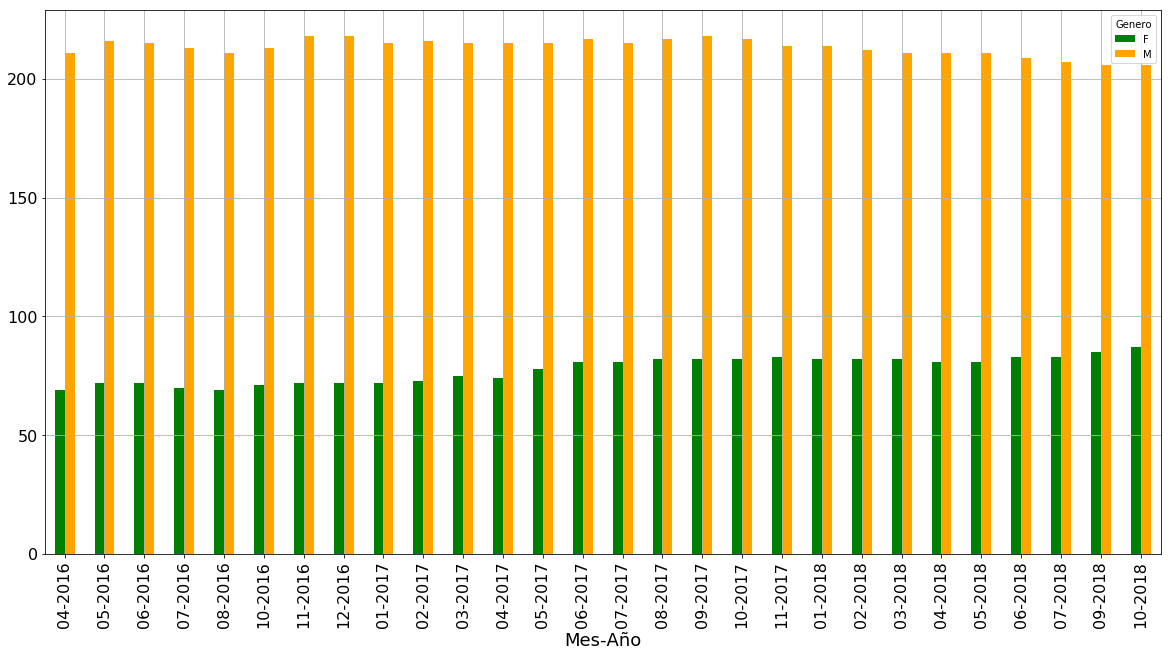

In [13]:
ax = pd_cat.groupby(by=['Mes','Genero']).count().unstack('Genero')['DOC'].plot(kind='bar',figsize=(20,10),fontsize=16,stacked=False,color=['green','orange'])
ax.set_xlabel('Total de Funcionarios x Genero',fontsize=16)
ax.set_xlabel('Mes-Año',fontsize=18)
ax.set_xticklabels(pd_cat.Mes.dt.strftime('%m-%Y').unique());
ax.grid(True)

#### Relativa

Vemos la contribución porcentual al total de funcionarios por género.

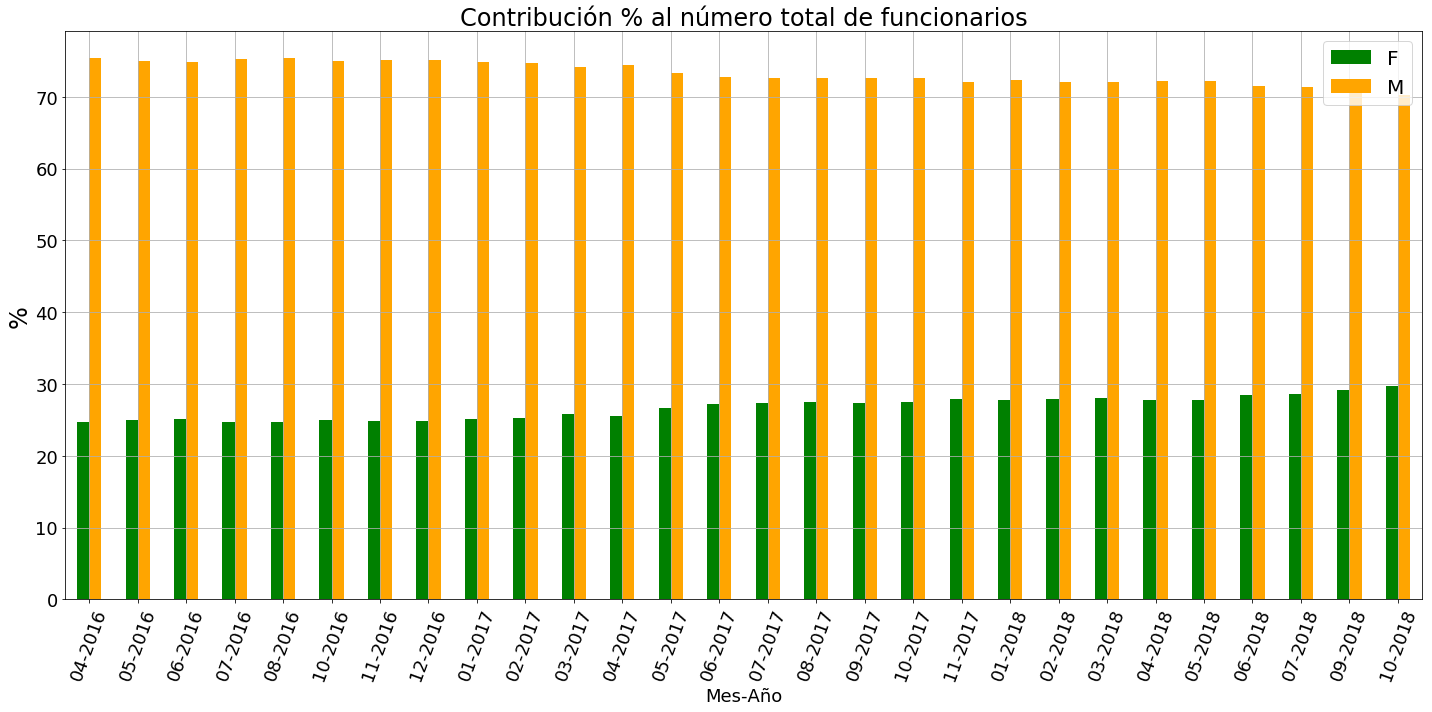

In [14]:
# Acomodamos un poco el DataFrame
pd_in=pd.DataFrame(pd_cat.groupby(by=['Mes','Genero']).count().unstack('Genero')['DOC'],columns=['F','M'])
pd_in['T']=pd_in['F']+pd_in['M']
pd_in['F_frac']=(pd_in['F']/pd_in['T'])*100
pd_in['M_frac']=(pd_in['M']/pd_in['T'])*100
# Visualizamos
ax=pd_in[['F_frac','M_frac']].plot(kind='bar',stacked=False,fontsize=18,figsize=(20,10),color=['green','orange'])
ax.set_ylabel('%',fontsize=24)
ax.set_title('Contribución % al número total de funcionarios',fontsize=24)
ax.set_xlabel('Mes-Año',fontsize=18)
ax.set_xticklabels(pd_in.index.strftime('%m-%Y').unique(),rotation=70);
ax.legend(['F','M'],fontsize=20);
ax.grid(True)
plt.tight_layout()
plt.savefig('img/genero_contrib_porcentual.png')

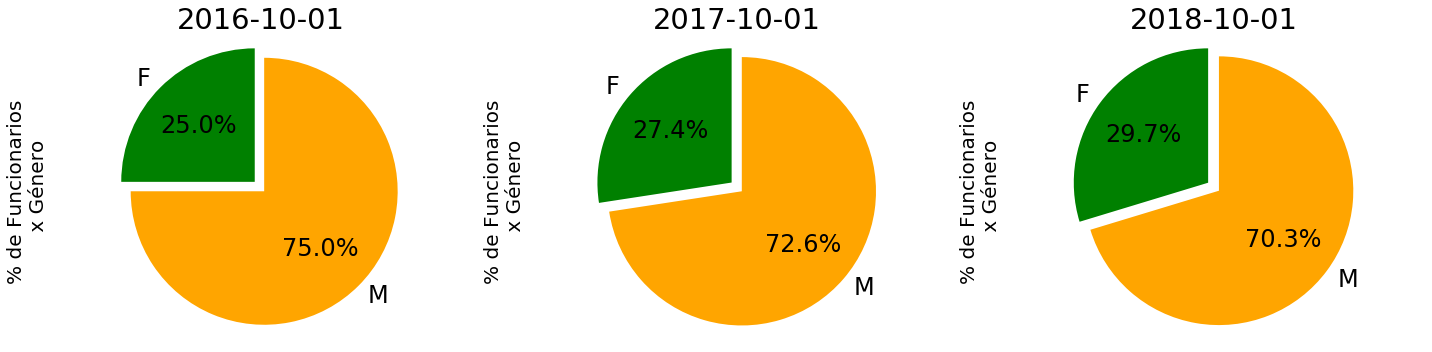

In [15]:
# Vemos algunos casos puntuales
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(1,3)
fig=plt.figure(figsize=(20,5))
used_month=[]
for k,i in enumerate(['2016-10-01','2017-10-01','2018-10-01'],start=0):
    ax = plt.subplot(gs[k])
    explode = (0, 0.1)
    pd_in[['F','M']].loc[i].plot(kind='pie',explode=explode,ax=ax,fontsize=24,autopct=lambda x: '{:1.1f}%'.format(x),colors=['green','orange'],startangle=90,shadow=False)
    ax.set_title(i,fontsize=29)
    ax.set_ylabel('% de Funcionarios \n x Género',fontsize=20)
    ax.axis('equal')
plt.tight_layout()
plt.savefig('img/genero_contrib_porcentual_cases.png')

Según se puede observar falta mucho para que la distribución
sea igualitaria , aunque el acumulado indica que las incorporaciones de género
F superan a las de género M (ver mas abajo).

### Veamos los ingresos y egresos

Hacemos el merge de los data frames filtrados por mes y revisamos cuales se renuevan, cuales dejan de estar y cuales ingresan.


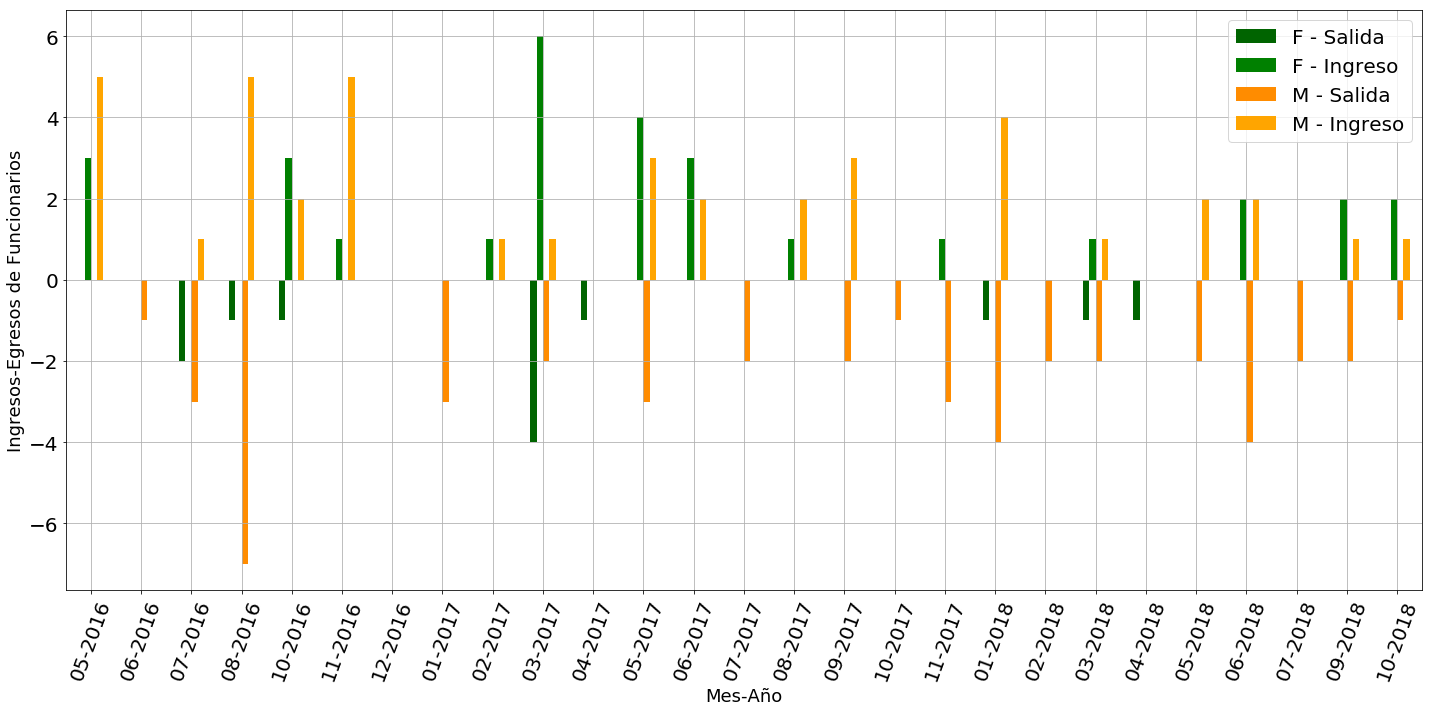

In [16]:
lst_mes=list(pd_cat.Mes.unique()); mes_count=len(lst_mes)
aux_pd=[]
for i in range(0,mes_count-1):
    pd_temp=pd.merge(pd_cat[pd_cat.Mes==lst_mes[i]],pd_cat[pd_cat.Mes==lst_mes[i+1]],how='outer',left_on='DOC_NUM',right_on='DOC_NUM',indicator=True)
    aux_pd.append(pd_temp)
# Al usar indicator==True nos da informacion respecto al origen de la informacion.
# Las opciones que esperamos son
#_merge: both,right_only,left_only
_merge=['left_only','left_only','right_only','right_only']
_gender=['Genero_x','Genero_x','Genero_y','Genero_y']
_gender_case=['F','M','F','M']

aux_m=[]
for pd_c in aux_pd:
    pd_temp=pd_c
    aux_c=[]
    for c in zip(_merge,_gender,_gender_case):
        x,y,z=c
        bool_0=np.logical_and(pd_temp._merge==x,pd_temp[y]==z)
        aux_c.append(len(pd_temp[bool_0]))
    aux_m.append(aux_c)
    
# Lo volvemos DataFrame
pd_out_in=pd.DataFrame(aux_m,index=lst_mes[1:],columns=['F_out','M_out','F_in','M_in'])
pd_out_in['F_diff']=pd_out_in['F_in']-pd_out_in['F_out']
pd_out_in['M_diff']=pd_out_in['M_in']-pd_out_in['M_out']
pd_out_in['X_diff']=pd_out_in['M_diff']+pd_out_in['F_diff']
#
pd_out_in['F_out']=-pd_out_in['F_out']
pd_out_in['M_out']=-pd_out_in['M_out']
##
ax=pd_out_in[['F_out','F_in','M_out','M_in']].plot(kind='bar',figsize=(20,10),fontsize=16,color=['darkgreen','green','darkorange','orange'])
ax.set_xticklabels(pd_out_in.index.strftime('%m-%Y').unique(),rotation=70);
ax.set_xlabel('Mes-Año',fontsize=18);
ax.set_ylabel('Ingresos-Egresos de Funcionarios',fontsize=18);
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(['F - Salida','F - Ingreso','M - Salida','M - Ingreso'],fontsize=20)
ax.grid(True)
plt.tight_layout()
plt.savefig('img/genero_ingresos_egresos_desglosado.png')

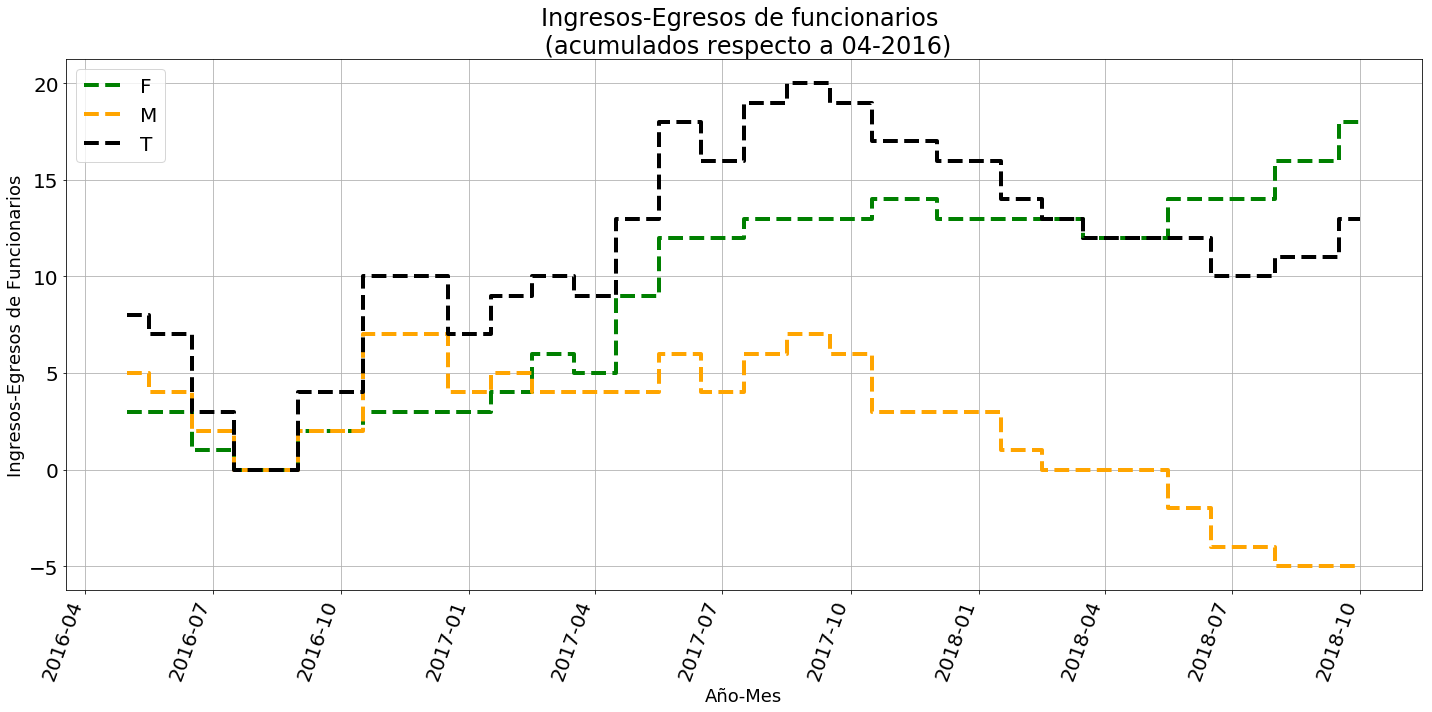

In [17]:
mpl.rc('lines',ls='--')
ax=pd_out_in[['F_diff','M_diff','X_diff']].cumsum().plot(kind='line',figsize=(20,10),color=['green','orange','black'],linewidth=4,drawstyle = 'steps-mid')
ax.set_xlabel('Año-Mes',fontsize=18);
ax.set_ylabel('Ingresos-Egresos de Funcionarios',fontsize=18);
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', rotation=70)
ax.set_title('Ingresos-Egresos de funcionarios \n (acumulados respecto a 04-2016)',fontsize=24)
ax.legend(['F','M','T'],fontsize=20)
ax.grid(True)
plt.tight_layout()
plt.savefig('img/genero_ingresos_egresos_cumsum.png')

<a id='genero_sueldo'></a>

## Distribución de Salarios


### Estadístico: Mediana

Veamos la distribución de Sueldo Bruto (utilizando la mediana) por género.

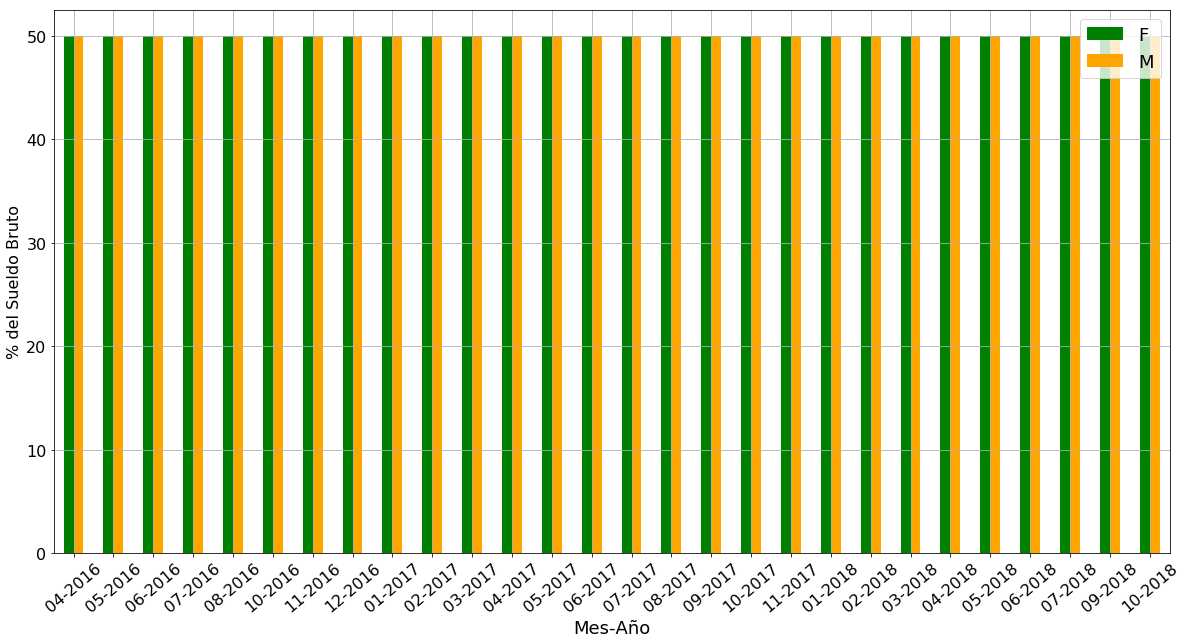

In [18]:
# Acomodamos un poco el DataFrame
pd_in=pd.DataFrame(pd_cat.groupby(by=['Mes','Genero']).median().unstack('Genero')['Sueldo Bruto'],columns=['F','M'])
pd_in['T']=pd_in['F']+pd_in['M']
pd_in['F_frac']=(pd_in['F']/pd_in['T'])*100
pd_in['M_frac']=(pd_in['M']/pd_in['T'])*100
# Visualizamos
ax=pd_in[['F_frac','M_frac']].plot(kind='bar',stacked=False,fontsize=16,figsize=(20,10),color=['green','orange'])
ax.set_ylabel('% del Sueldo Bruto',fontsize=16)
ax.set_xlabel('Mes-Año',fontsize=18);
ax.set_xticklabels(pd_in.index.strftime('%m-%Y').unique(),rotation=40);
ax.legend(['F','M'],fontsize=18);
ax.grid(True)
plt.show()

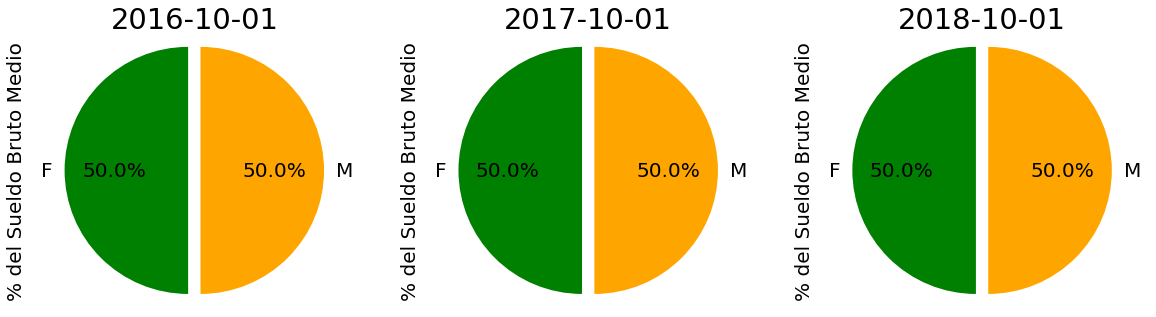

In [19]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(1,3)
fig=plt.figure(figsize=(20,5))
used_month=[]
for k,i in enumerate(['2016-10-01','2017-10-01','2018-10-01'],start=0):
    ax = plt.subplot(gs[k])
    explode = (0, 0.1)
    pd_in[['F','M']].loc[i].plot(kind='pie',explode=explode,ax=ax,fontsize=20,autopct=lambda x: '{:1.1f}%'.format(x),colors=['green','orange'],startangle=90,shadow=False)
    ax.set_title(i,fontsize=29)
    ax.set_ylabel('% del Sueldo Bruto Medio',fontsize=20)
    ax.axis('equal')
plt.show()

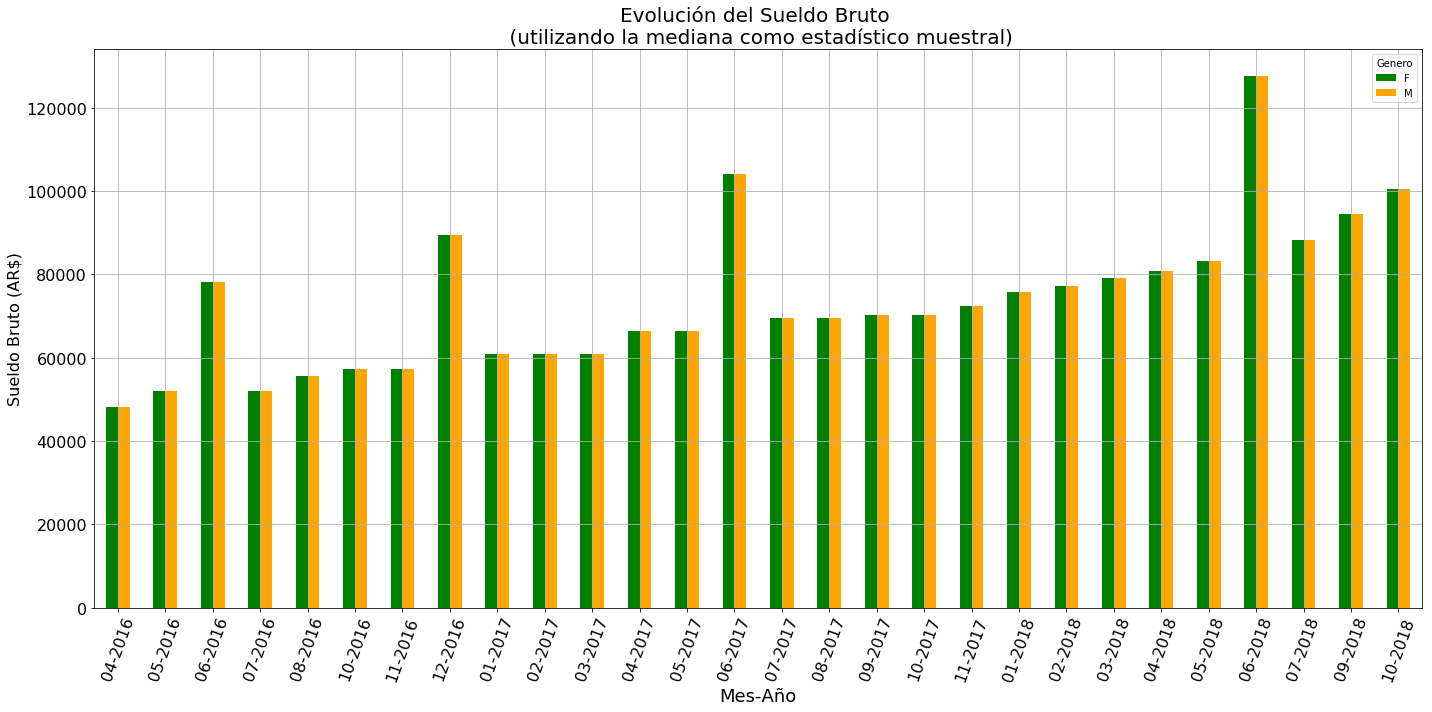

In [20]:
#
case_plt='Sueldo Bruto'
ax=pd_cat.groupby(by=['Mes','Genero']).median().unstack('Genero')[case_plt].plot(kind='bar',figsize=(20,10),fontsize=16,color=['green','orange'])
ax.set_xlabel('Mes-Año',fontsize=18);
ax.set_xticklabels(pd_cat.Mes.dt.strftime('%m-%Y').unique(),rotation=70,fontsize=16);
ax.set_ylabel(case_plt +' (AR\$)',fontsize=16,rotation=90);
ax.grid(True)
ax.set_title('Evolución del Sueldo Bruto \n (utilizando la mediana como estadístico muestral)',fontsize=20);
plt.tight_layout()
plt.savefig('img/sueldo_evolucion_sueldo_bruto_mediana.png')

La misma muestra paridad en cuanto a género (esto parece
consistente con un esquema de escalas salariales).

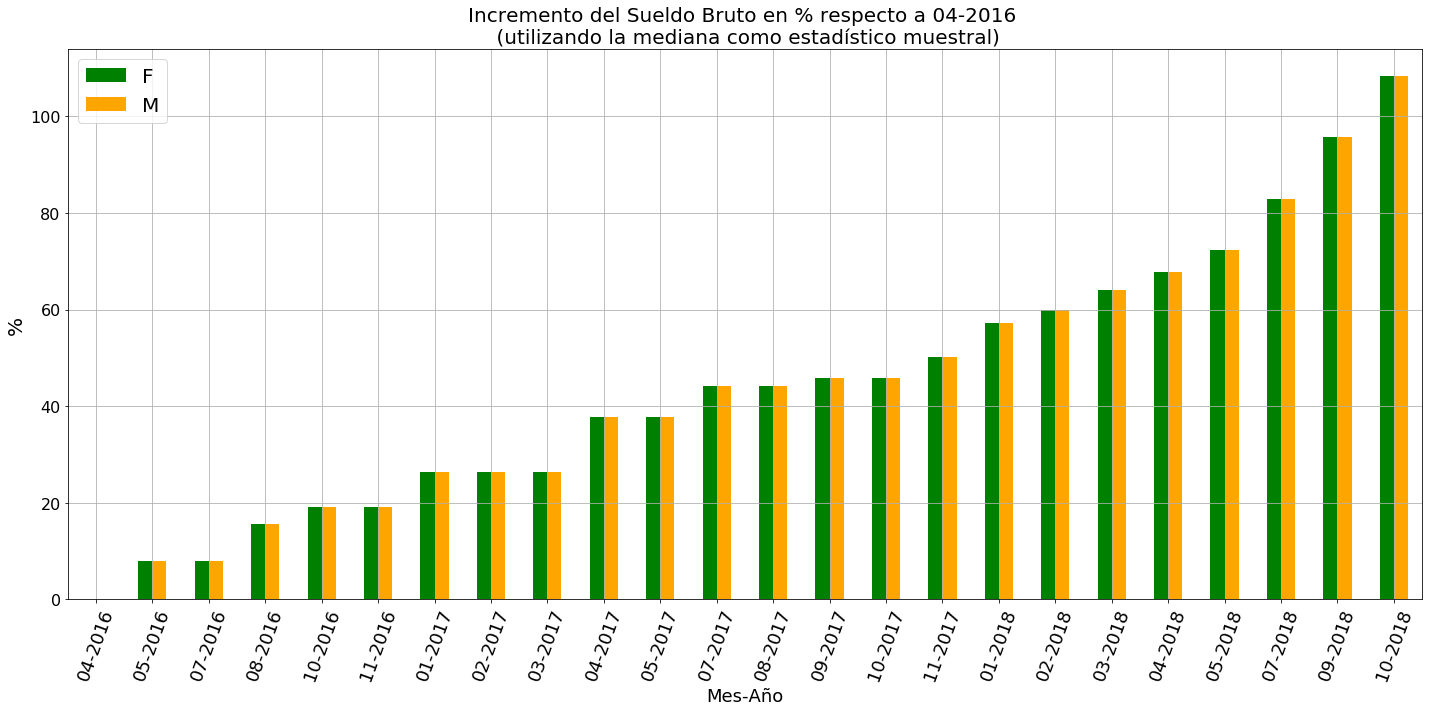

In [21]:
pd_cat['mes_num']=pd_cat['Mes'].apply(lambda x:x.month)
pd_cat_inf=pd_cat[np.logical_and(pd_cat.mes_num!=6,pd_cat.mes_num!=12)].copy()
pd_grouped=pd.DataFrame(pd_cat_inf.groupby(by=['Mes','Genero']).median().unstack('Genero')[case_plt].reset_index())
pd_grouped['F']=(pd_grouped['F']/pd_grouped['F'].loc[0]-1)*100
pd_grouped['M']=(pd_grouped['M']/pd_grouped['M'].loc[0]-1)*100
ax=pd_grouped[['F','M']].plot(kind='bar',figsize=(20,10),fontsize=16,color=['green','orange'])
ax.set_xticklabels(pd_grouped.Mes.dt.strftime('%m-%Y').unique(),rotation=70,fontsize=18);
ax.set_xlabel('Mes-Año',fontsize=18);
ax.set_ylabel('%',fontsize=20);
ax.set_title('Incremento del Sueldo Bruto en % respecto a 04-2016 \n (utilizando la mediana como estadístico muestral)',fontsize=20);
ax.legend(fontsize=20)
ax.grid(True)
plt.tight_layout()
plt.savefig('img/sueldo_evolucion_sueldo_bruto_mediana_porcentual.png')

A partir de esta figura observamos que el Salario Bruto se incremento un cerca del 40% en un año y un 70% para el segundo año (tomando como base 04-2016).

### Estadístico: Media
Veamos la distribución de Sueldo Bruto (utilizando la media) por género.

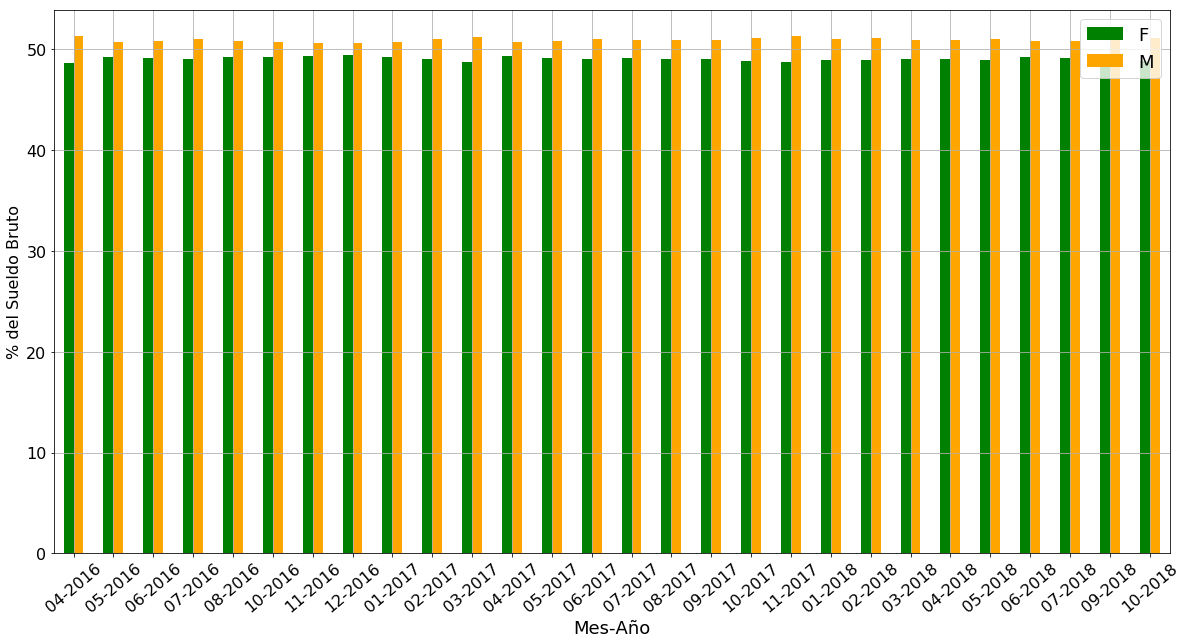

In [22]:
# Acomodamos un poco el DataFrame
pd_in=pd.DataFrame(pd_cat.groupby(by=['Mes','Genero']).mean().unstack('Genero')['Sueldo Bruto'],columns=['F','M'])
pd_in['T']=pd_in['F']+pd_in['M']
pd_in['F_frac']=(pd_in['F']/pd_in['T'])*100
pd_in['M_frac']=(pd_in['M']/pd_in['T'])*100
# Visualizamos
ax=pd_in[['F_frac','M_frac']].plot(kind='bar',stacked=False,fontsize=16,figsize=(20,10),color=['green','orange'])
ax.set_ylabel('% del Sueldo Bruto',fontsize=16)
ax.set_xlabel('Mes-Año',fontsize=18);
ax.set_xticklabels(pd_in.index.strftime('%m-%Y').unique(),rotation=40);
ax.legend(['F','M'],fontsize=18);
ax.grid(True)
plt.show()

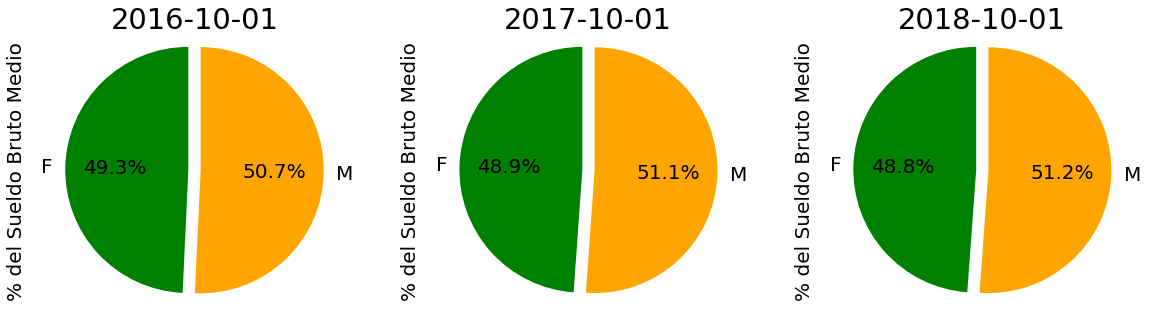

In [23]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(1,3)
fig=plt.figure(figsize=(20,5))
used_month=[]
for k,i in enumerate(['2016-10-01','2017-10-01','2018-10-01'],start=0):
    ax = plt.subplot(gs[k])
    explode = (0, 0.1)
    pd_in[['F','M']].loc[i].plot(kind='pie',explode=explode,ax=ax,fontsize=20,autopct=lambda x: '{:1.1f}%'.format(x),colors=['green','orange'],startangle=90,shadow=False)
    ax.set_title(i,fontsize=29)
    ax.set_ylabel('% del Sueldo Bruto Medio',fontsize=20)
    ax.axis('equal')
plt.show()

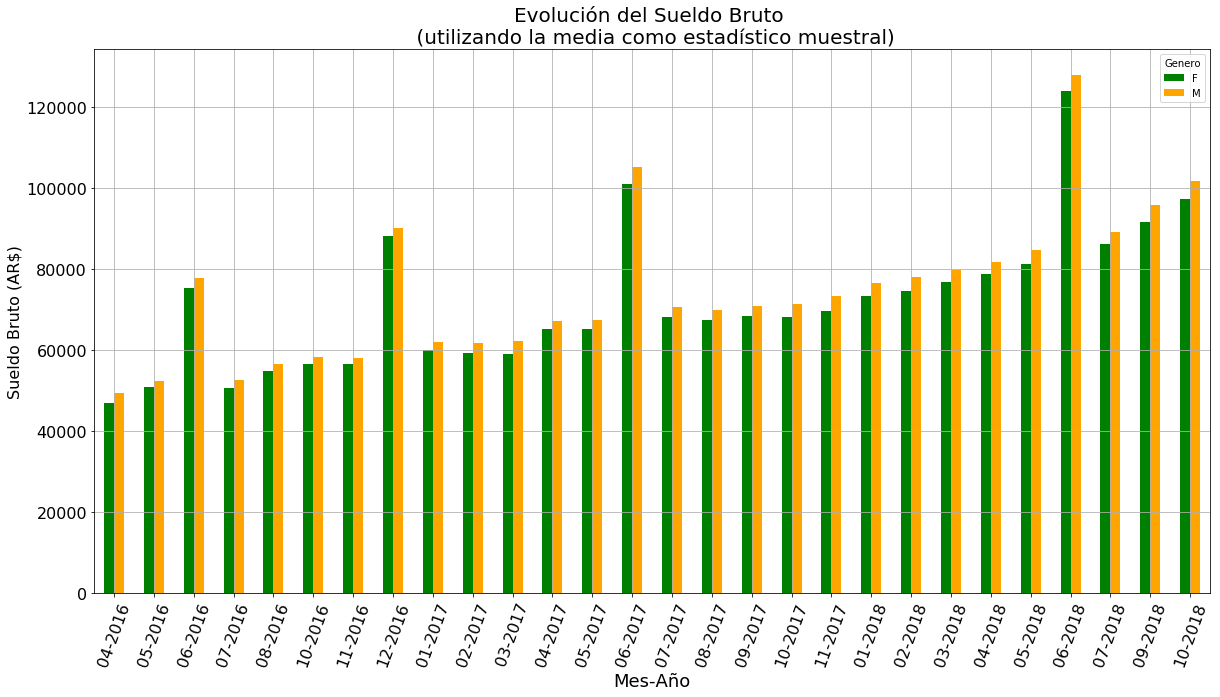

In [24]:
#
case_plt='Sueldo Bruto'
ax=pd_cat.groupby(by=['Mes','Genero']).mean().unstack('Genero')[case_plt].plot(kind='bar',figsize=(20,10),fontsize=16,color=['green','orange'])
ax.set_xlabel('Mes-Año',fontsize=18);
ax.set_xticklabels(pd_cat.Mes.dt.strftime('%m-%Y').unique(),rotation=70,fontsize=16);
ax.set_ylabel(case_plt +' (AR\$)',fontsize=16,rotation=90);
ax.grid(True)
ax.set_title('Evolución del Sueldo Bruto \n (utilizando la media como estadístico muestral)',fontsize=20);

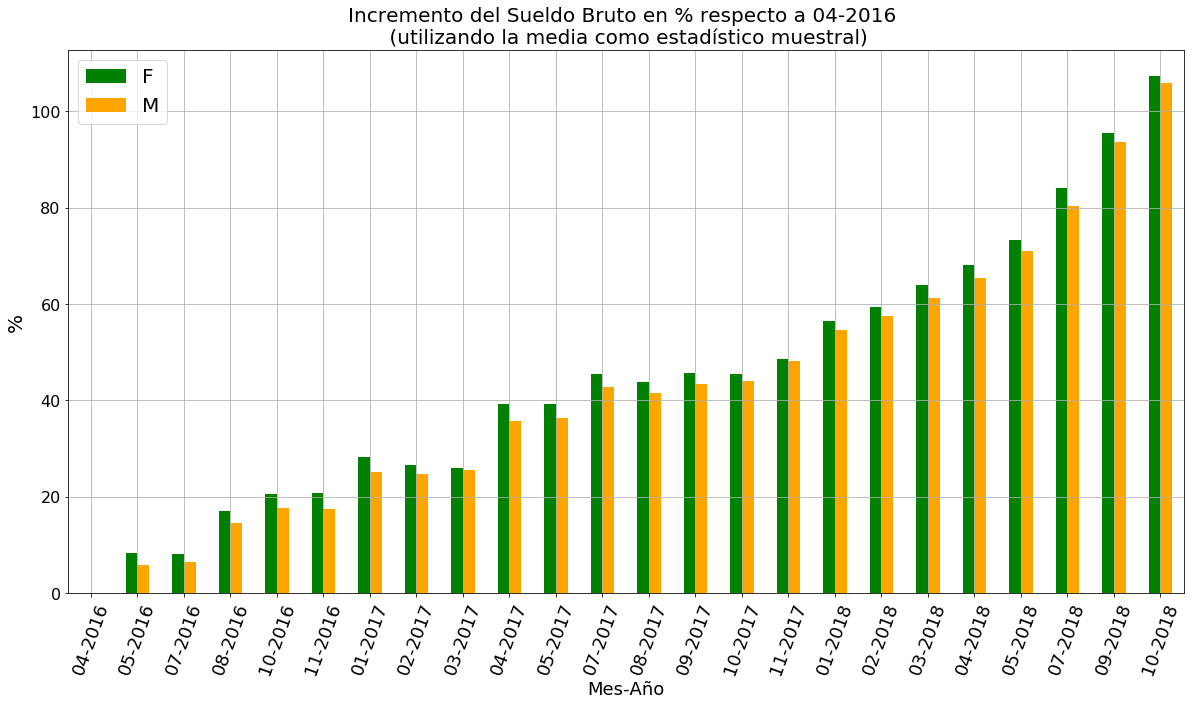

In [25]:
pd_cat['mes_num']=pd_cat['Mes'].apply(lambda x:x.month)
pd_cat_inf=pd_cat[np.logical_and(pd_cat.mes_num!=6,pd_cat.mes_num!=12)].copy()
pd_grouped=pd.DataFrame(pd_cat_inf.groupby(by=['Mes','Genero']).mean().unstack('Genero')[case_plt].reset_index())
pd_grouped['F']=(pd_grouped['F']/pd_grouped['F'].loc[0]-1)*100
pd_grouped['M']=(pd_grouped['M']/pd_grouped['M'].loc[0]-1)*100
ax=pd_grouped[['F','M']].plot(kind='bar',figsize=(20,10),fontsize=16,color=['green','orange'])
ax.set_xticklabels(pd_grouped.Mes.dt.strftime('%m-%Y').unique(),rotation=70,fontsize=18);
ax.set_xlabel('Mes-Año',fontsize=18);
ax.set_ylabel('%',fontsize=20);
ax.set_title('Incremento del Sueldo Bruto en % respecto a 04-2016 \n (utilizando la media como estadístico muestral)',fontsize=20);
ax.legend(fontsize=20)
ax.grid(True)

### Evolución del Salario - Distribución

En lo que sigue observamos la distribución de los los salarios.

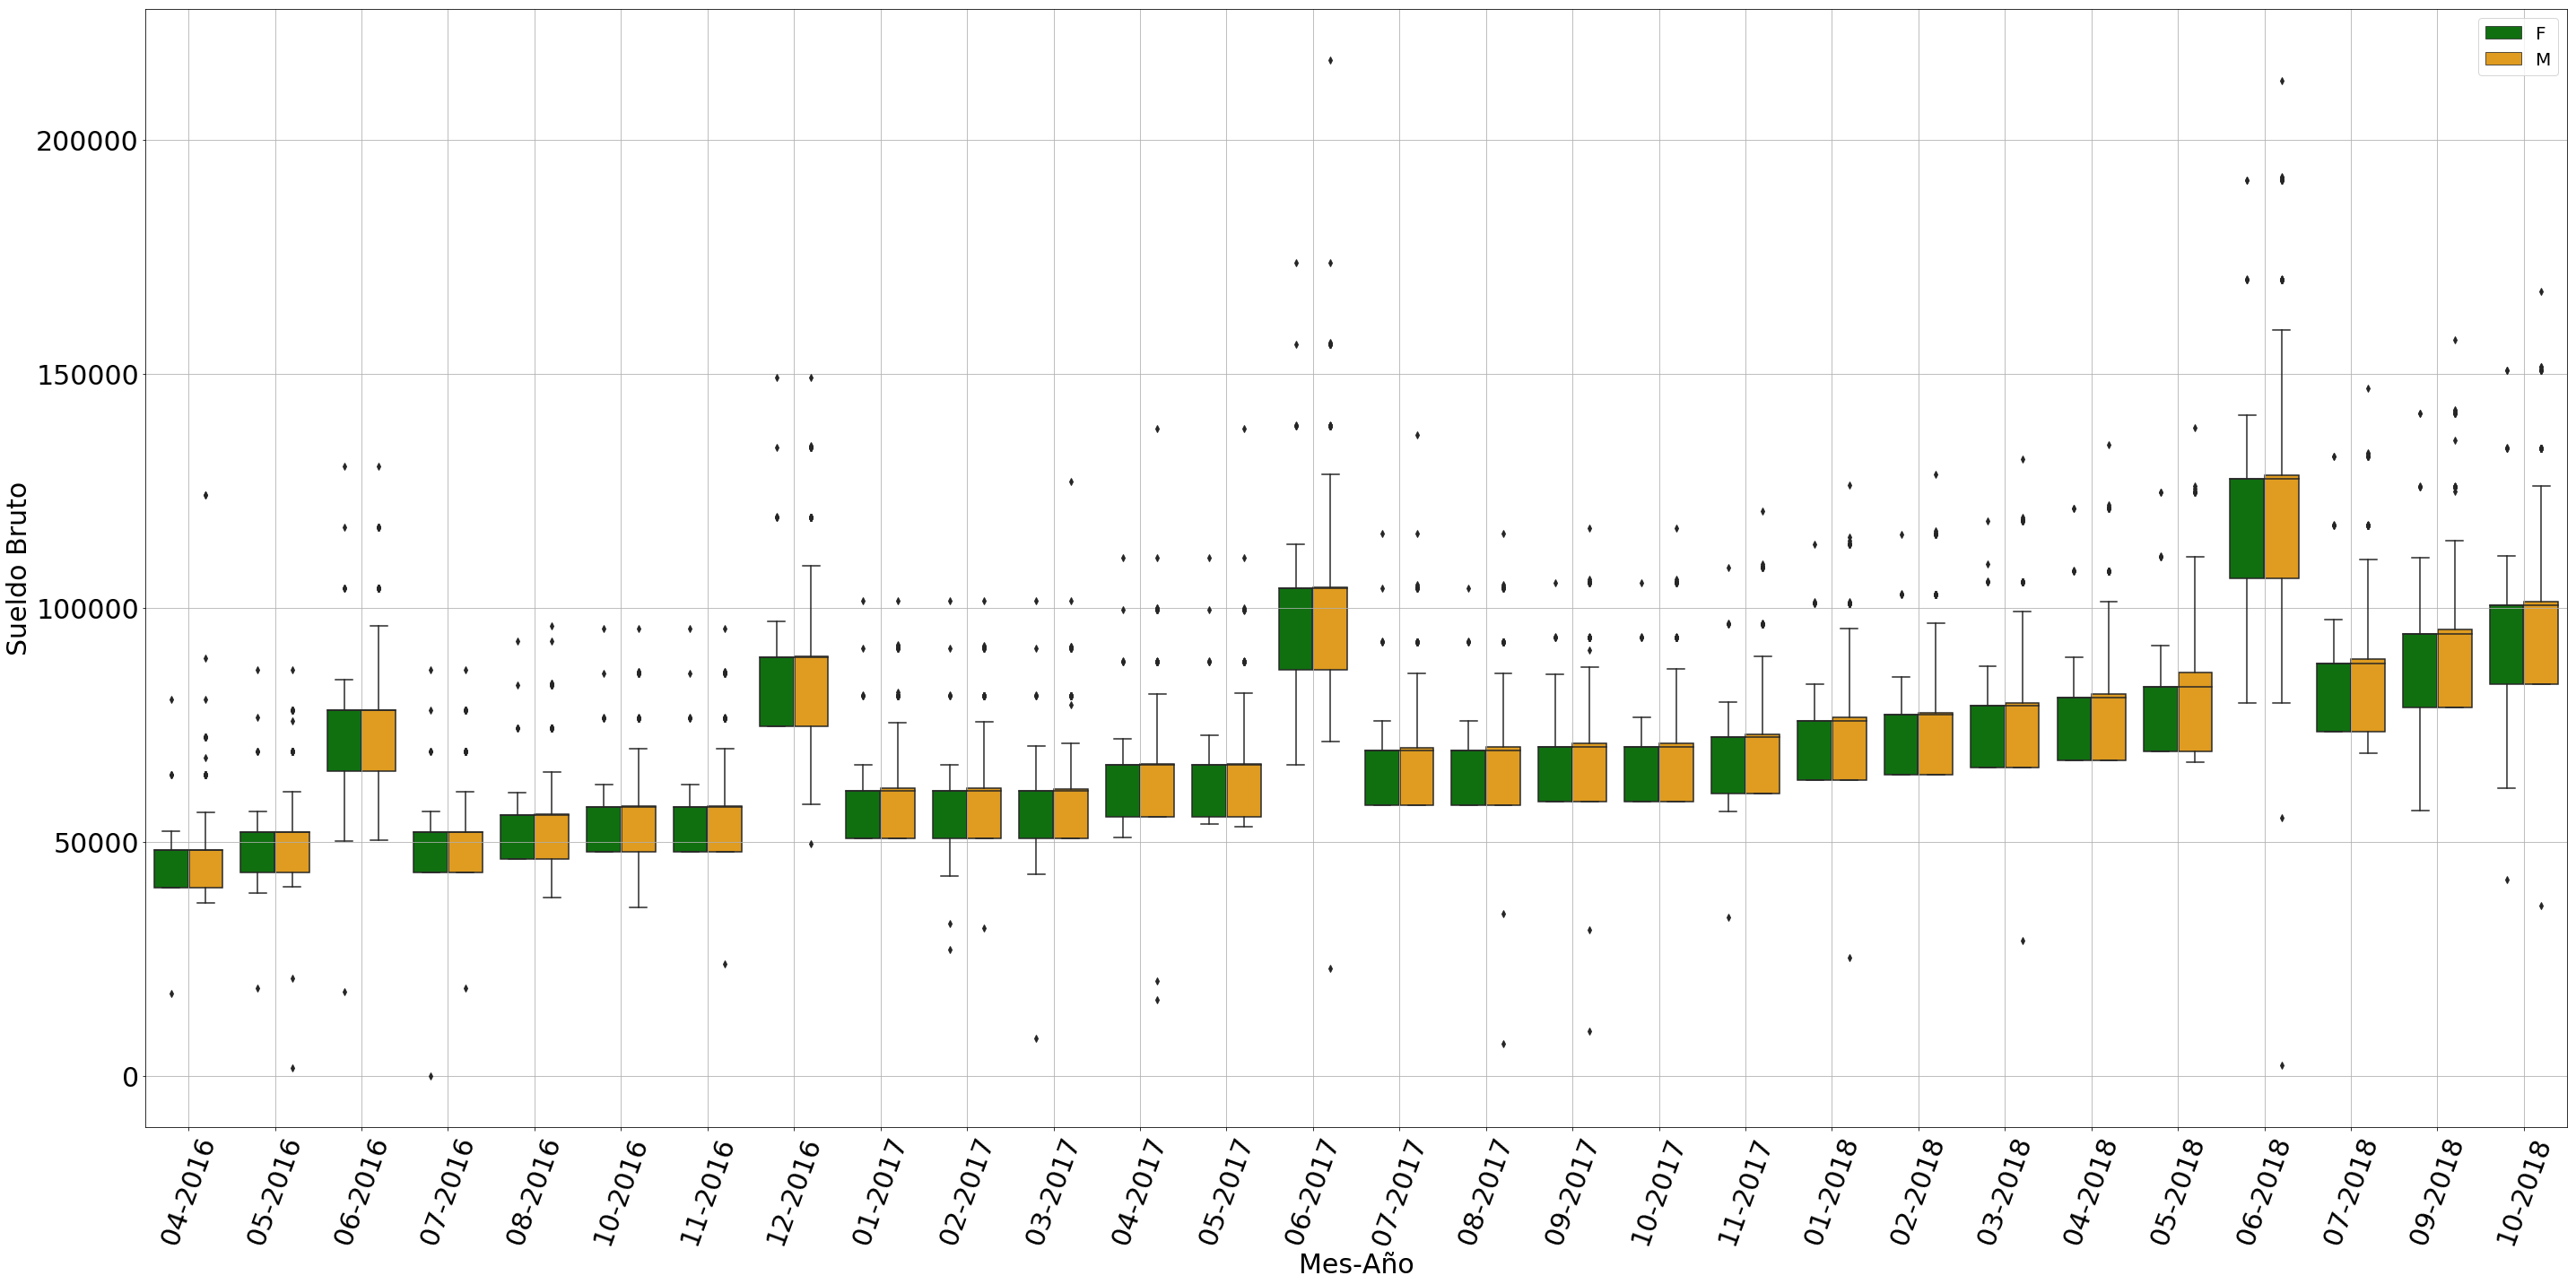

In [26]:
case_plt='Sueldo Bruto'
f,ax=plt.subplots(1,1,figsize=(40,20))
my_pal = {'F': "green", 'M': "orange"}
sns.boxplot(x="Mes", y=case_plt, hue="Genero", data=pd_cat,ax=ax,palette=my_pal,)
ax.set_xticklabels(pd_cat.Mes.dt.strftime('%m-%Y').unique(),rotation=70,fontsize=16);
ax.set_xlabel('Mes-Año',fontsize=30);
ax.tick_params(axis='both', which='major', labelsize=30)
ax.set_ylabel(case_plt,fontsize=30);
ax.legend(fontsize=20)
ax.grid(True)
plt.tight_layout()
plt.savefig('data/sueldo_distribucion.png')

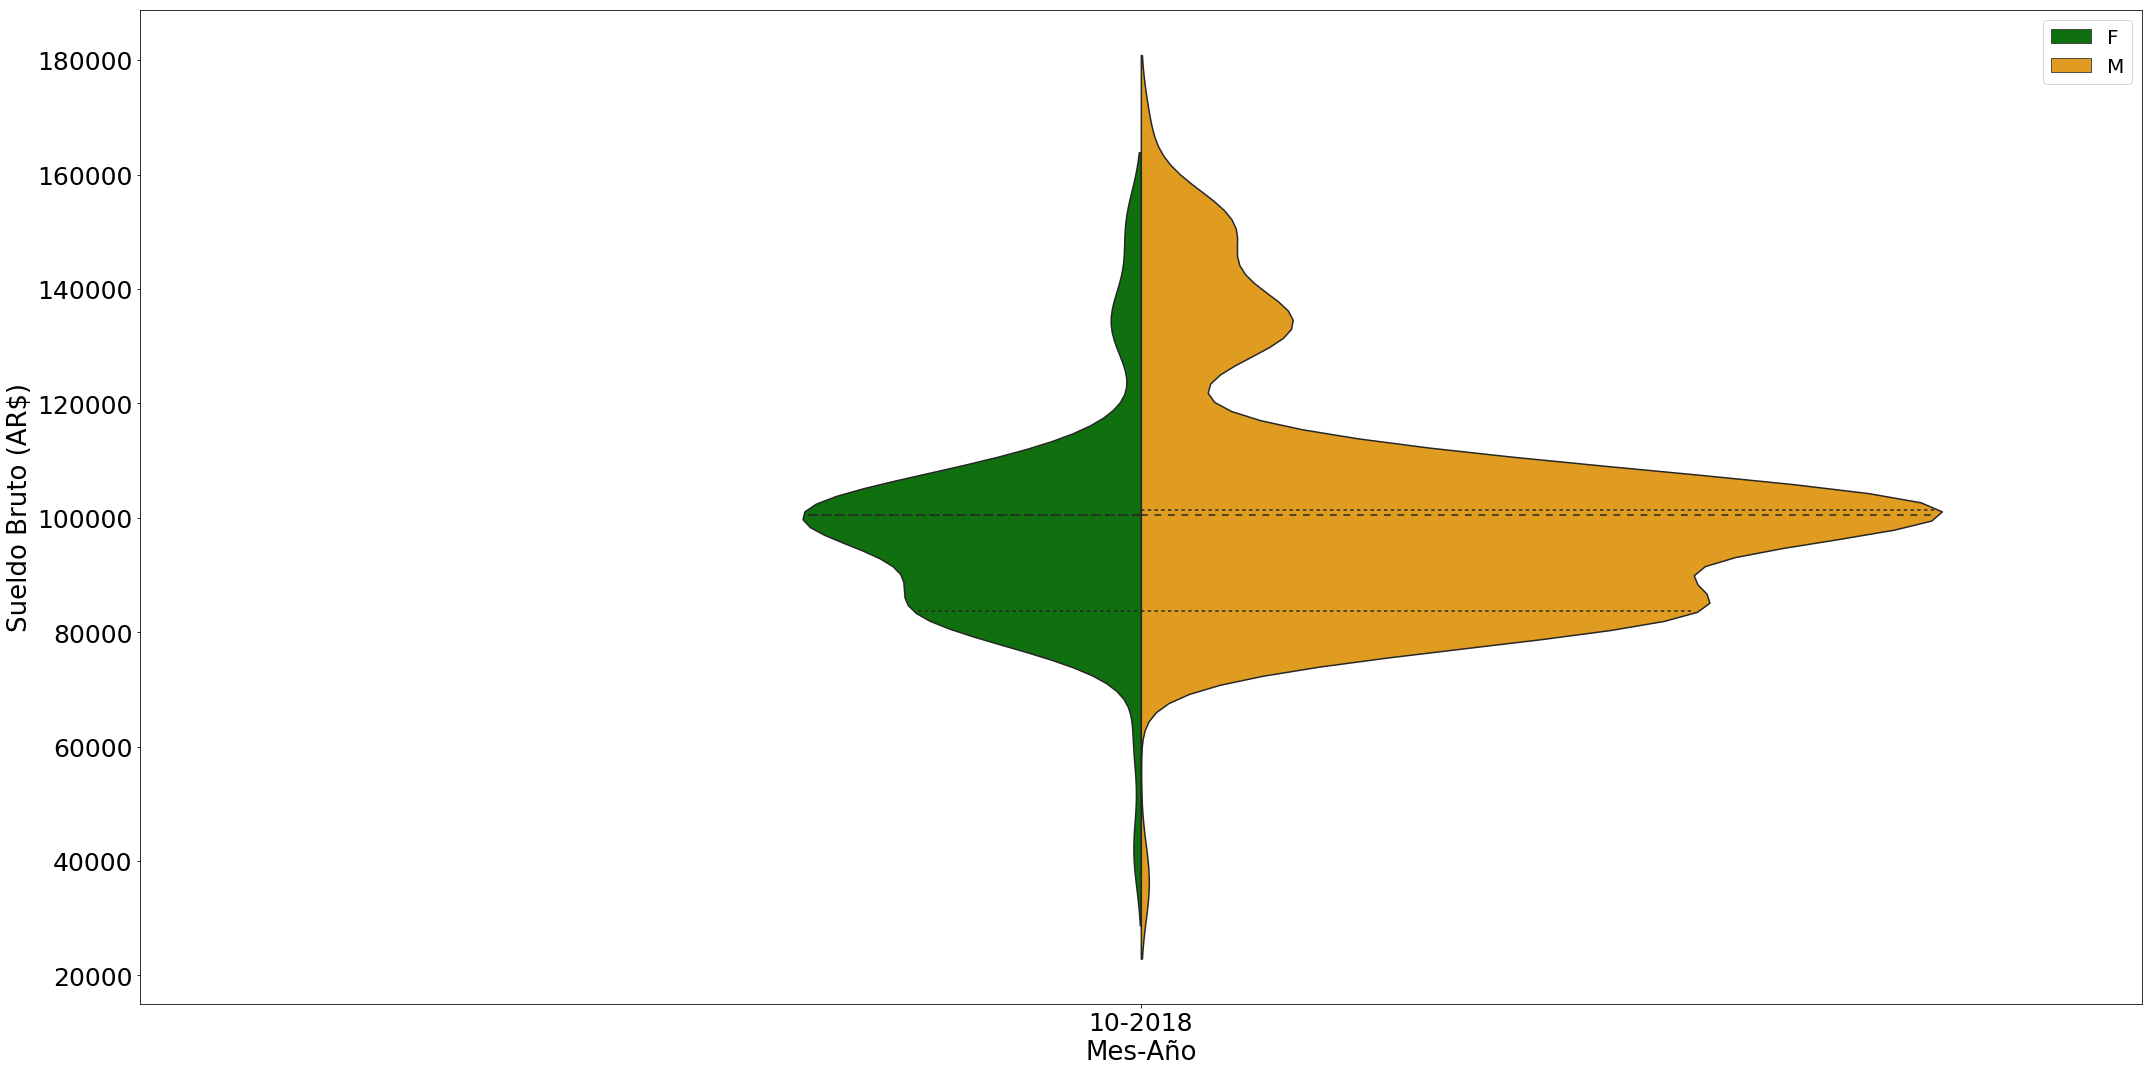

In [27]:
f,ax=plt.subplots(1,1,figsize=(30,15))
pd_cat_time_index=pd_cat.set_index(pd.DatetimeIndex(pd_cat['Mes']))
time_start='2018-10-01'
case_plt='Sueldo Bruto'
my_pal = {'F': "green", 'M': "orange"}
sns.violinplot(x='Mes',y=case_plt, hue="Genero", data=pd_cat_time_index[time_start:],ax=ax,palette=my_pal,split=True,scale_hue=True,scale='count',inner='quartile')
#sns.swarmplot(x='Mes',y=case_plt, hue="Genero", data=pd_cat_time_index[time_start:],ax=ax,palette=my_pal,dodge=True,size=10)
ax.set_xticklabels(pd_cat_time_index[time_start:].Mes.dt.strftime('%m-%Y').unique(),rotation=0,fontsize=26);
ax.set_xlabel('Mes-Año',fontsize=26);
ax.set_ylabel(case_plt +" (AR$)",fontsize=26);
ax.tick_params(axis='both', which='major', labelsize=25)
ax.legend(fontsize=20)
plt.tight_layout()
plt.savefig('img/sueldo_sueldo_bruto_dist_201810.png')

El último par de gráficas parecen indicar paridad en los sueldos brutos inclusive las distribuciones son similares (en la imagen mostramos para el mes 10-2018).Pero la cuestion parece estar en el balance nuevamente de los géneros. En el swarm-plot siguiente, observamos primero que la contribución por género en las distintas
escalas es menor para "F" que para "M" y esto se pone de manifiesto en mayor manera al subir la escala salarial.  


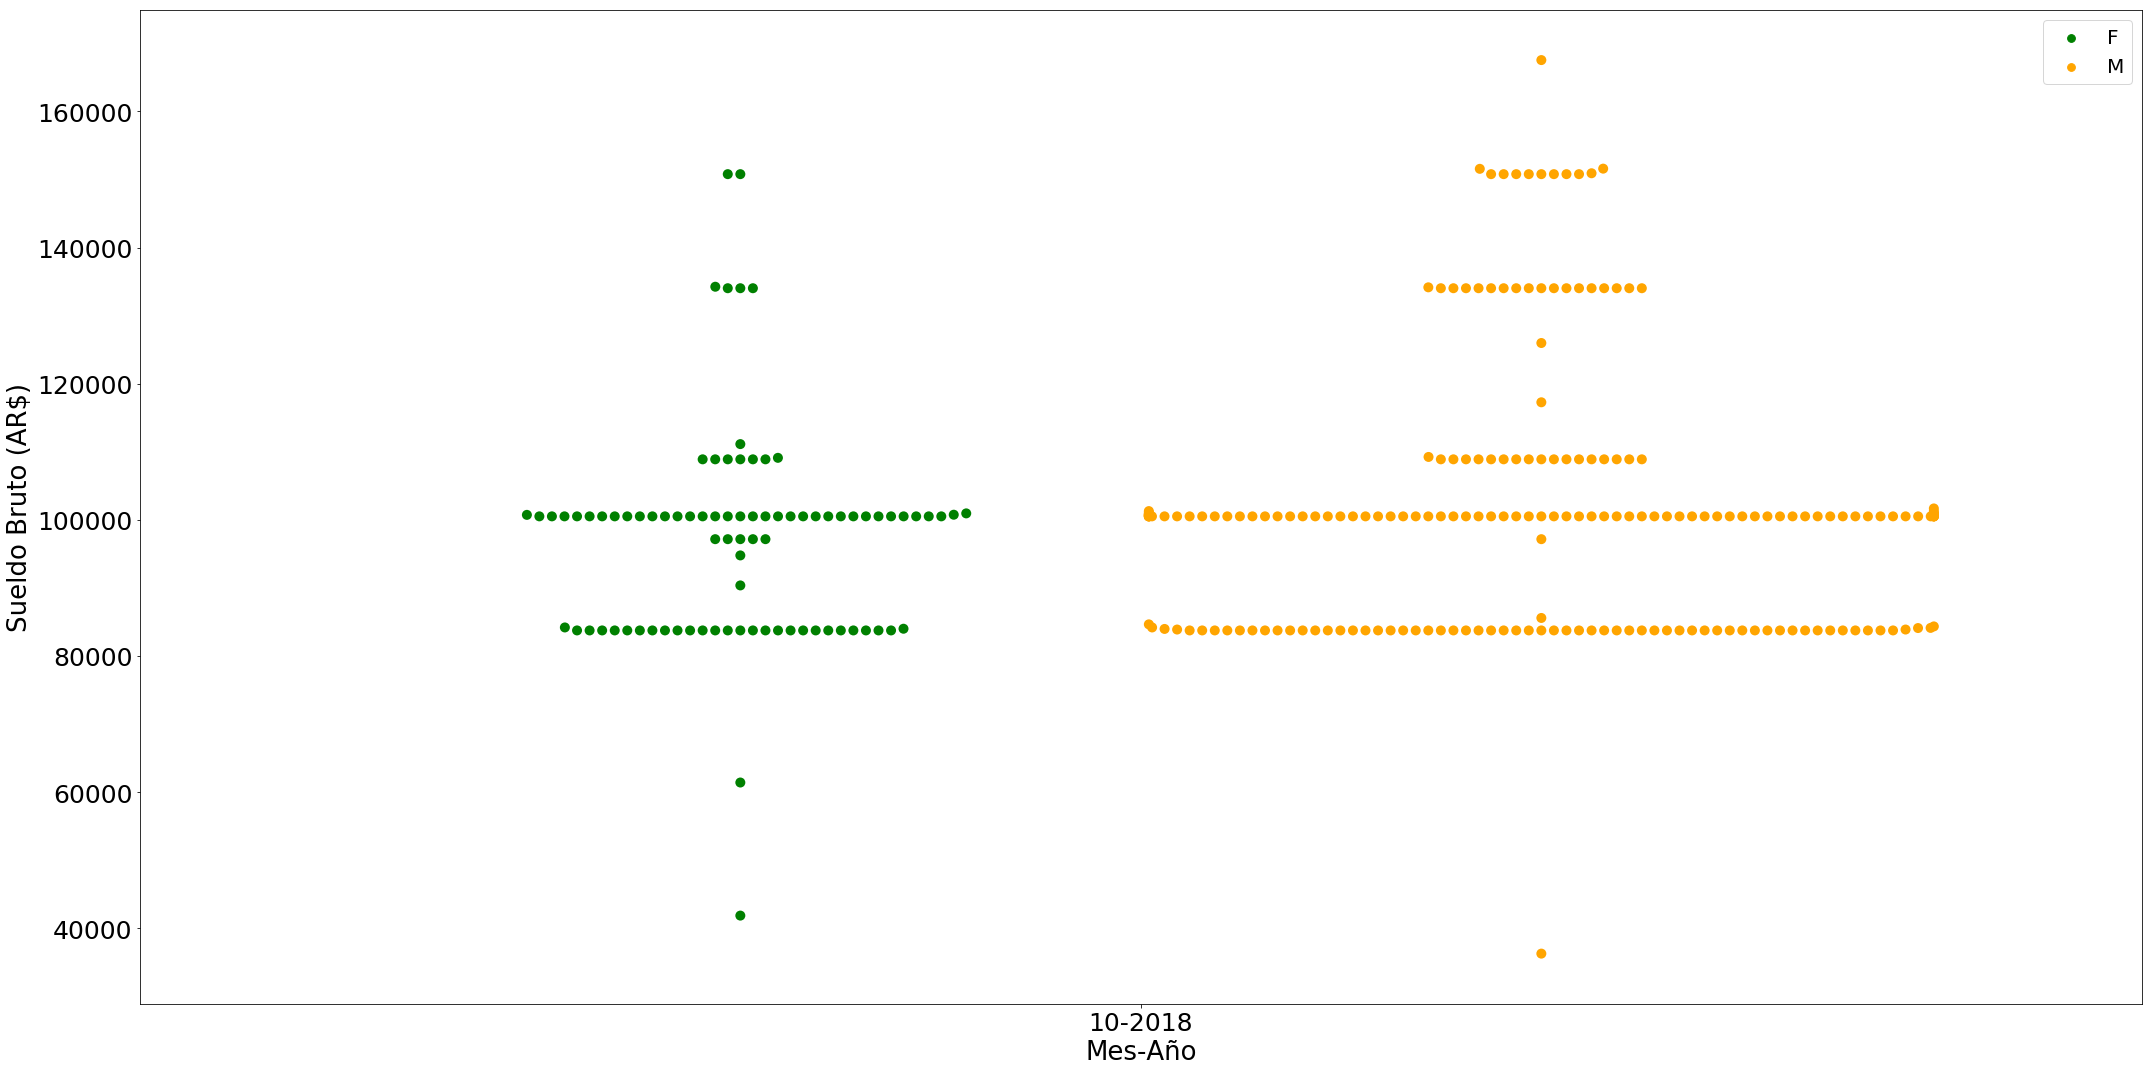

In [28]:
f,ax=plt.subplots(1,1,figsize=(30,15))
pd_cat_time_index=pd_cat.set_index(pd.DatetimeIndex(pd_cat['Mes']))
time_start='2018-10-01'
case_plt='Sueldo Bruto'
my_pal = {'F': "green", 'M': "orange"}
sns.swarmplot(x='Mes',y=case_plt, hue="Genero", data=pd_cat_time_index[time_start:],ax=ax,palette=my_pal,dodge=True,size=10)
ax.set_xticklabels(pd_cat_time_index[time_start:].Mes.dt.strftime('%m-%Y').unique(),rotation=0,fontsize=26);
ax.set_xlabel('Mes-Año',fontsize=26);
ax.set_ylabel(case_plt +" (AR$)",fontsize=26);
ax.tick_params(axis='both', which='major', labelsize=25)
ax.legend(fontsize=20)
plt.tight_layout()
plt.savefig('img/sueldo_sueldo_bruto_dist_swarm_201810.png')

<a id='genero_sueldo_dni'></a>

## Distribución (por DNI) de los Funcionarios

En lo siguiente analizamos la distribucion de los funcionarios por DNI. Con la salvedad de los extranjeros (DNI >90.000.000), esto nos da una idea de la distribución de edades de los funcionarios.

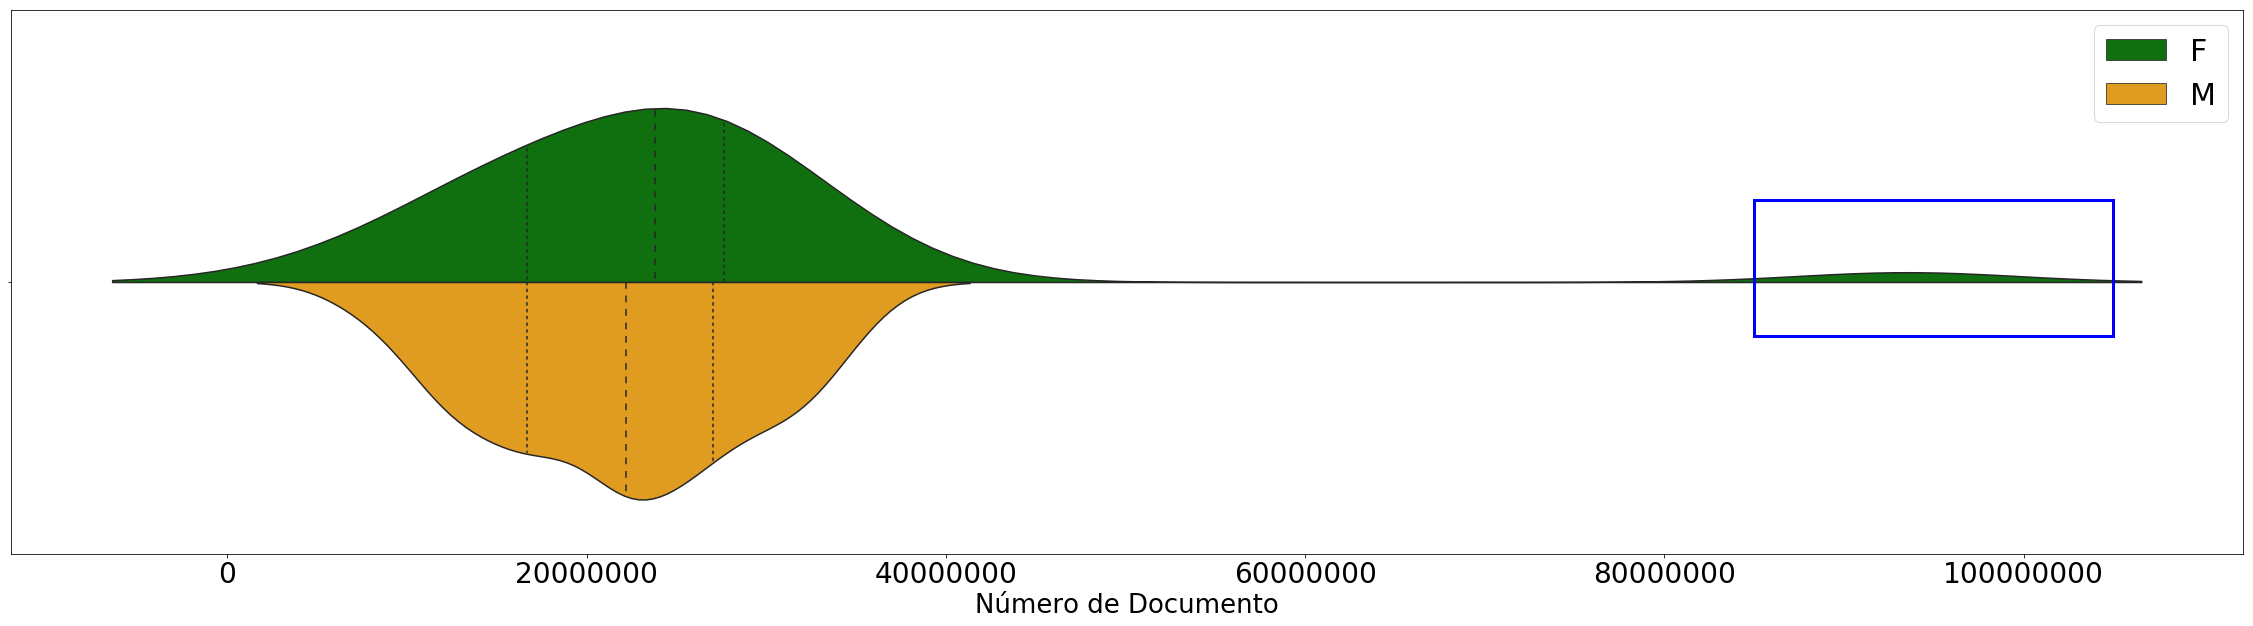

In [29]:
from matplotlib.ticker import FormatStrFormatter
from matplotlib import patches
f,ax=plt.subplots(1,1,figsize=(40,10))
pd_temp=pd_cat_time_index[time_start:time_start]
pd_data=pd_temp[pd_temp.DOC_NUM<6e8]
ax_s=sns.violinplot(x='DOC_NUM',y='DOC_EMS',hue='Genero',hue_order=['F','M'], data=pd_data,ax=ax,inner='quartile',split=True,palette=my_pal)
ax.set_yticklabels([]);
ax.set_ylabel('')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.d'))
ax.set_xlabel('Número de Documento',fontsize=26);
ax.tick_params(axis='both', which='major', labelsize=28)
ax.legend(fontsize=30)
ax_s.add_patch(patches.Rectangle((85e6, -0.15), 20e6, 
                        0.25,fill=False,edgecolor='blue',lw=3));

In [30]:
# aux funcs
def getDocRange(val,np_array):
    levels=len(np_array)
    val_tmp=val-np_array
    val_tmp_abs=abs(val_tmp)
    idx=np.argmin(val_tmp_abs)
    if val>max(np_array):
        return levels+1
    elif val<min(np_array):
        return -1
    else:
        if val_tmp[idx]>0:
            return idx
        else:
            return idx-1
# Separamos los rangos en 5M
bnds=np.arange(5e6,65e6,5e6)
# 
dict_bnds={}
dict_bnds.update({str(-1):'{:}<'.format(bnds[0]/10**6)})
for x in range(0,len(bnds)):
    dict_bnds.update({str(x):'{}'.format(str(bnds[x]/10**6))})
dict_bnds.update({str(len(bnds)+1):'>{:}'.format(bnds[-1]/10**6)})
# Calc Doc Range
pd_cat_time_index['DOC_RNG']=pd_cat_time_index['DOC_NUM'].apply(lambda x: getDocRange(x,bnds))
#
def set_gender_num(pd_data,ymax,ax,offset=0.25,fontsize=16):
    a=pd_data.groupby(by=['Genero','DOC_RNG'])['DOC_NUM'].count().unstack('DOC_RNG')
    x_ticks=ax.get_xticks()
    aux=[]
    for x in zip(a.loc['F'],a.loc['M']):
        aux.append(('{:s}'.format(str(x)).replace('nan','0')))
    for i,x in enumerate(x_ticks):
        ax.text(x-offset,ymax,aux[i],fontsize=fontsize)

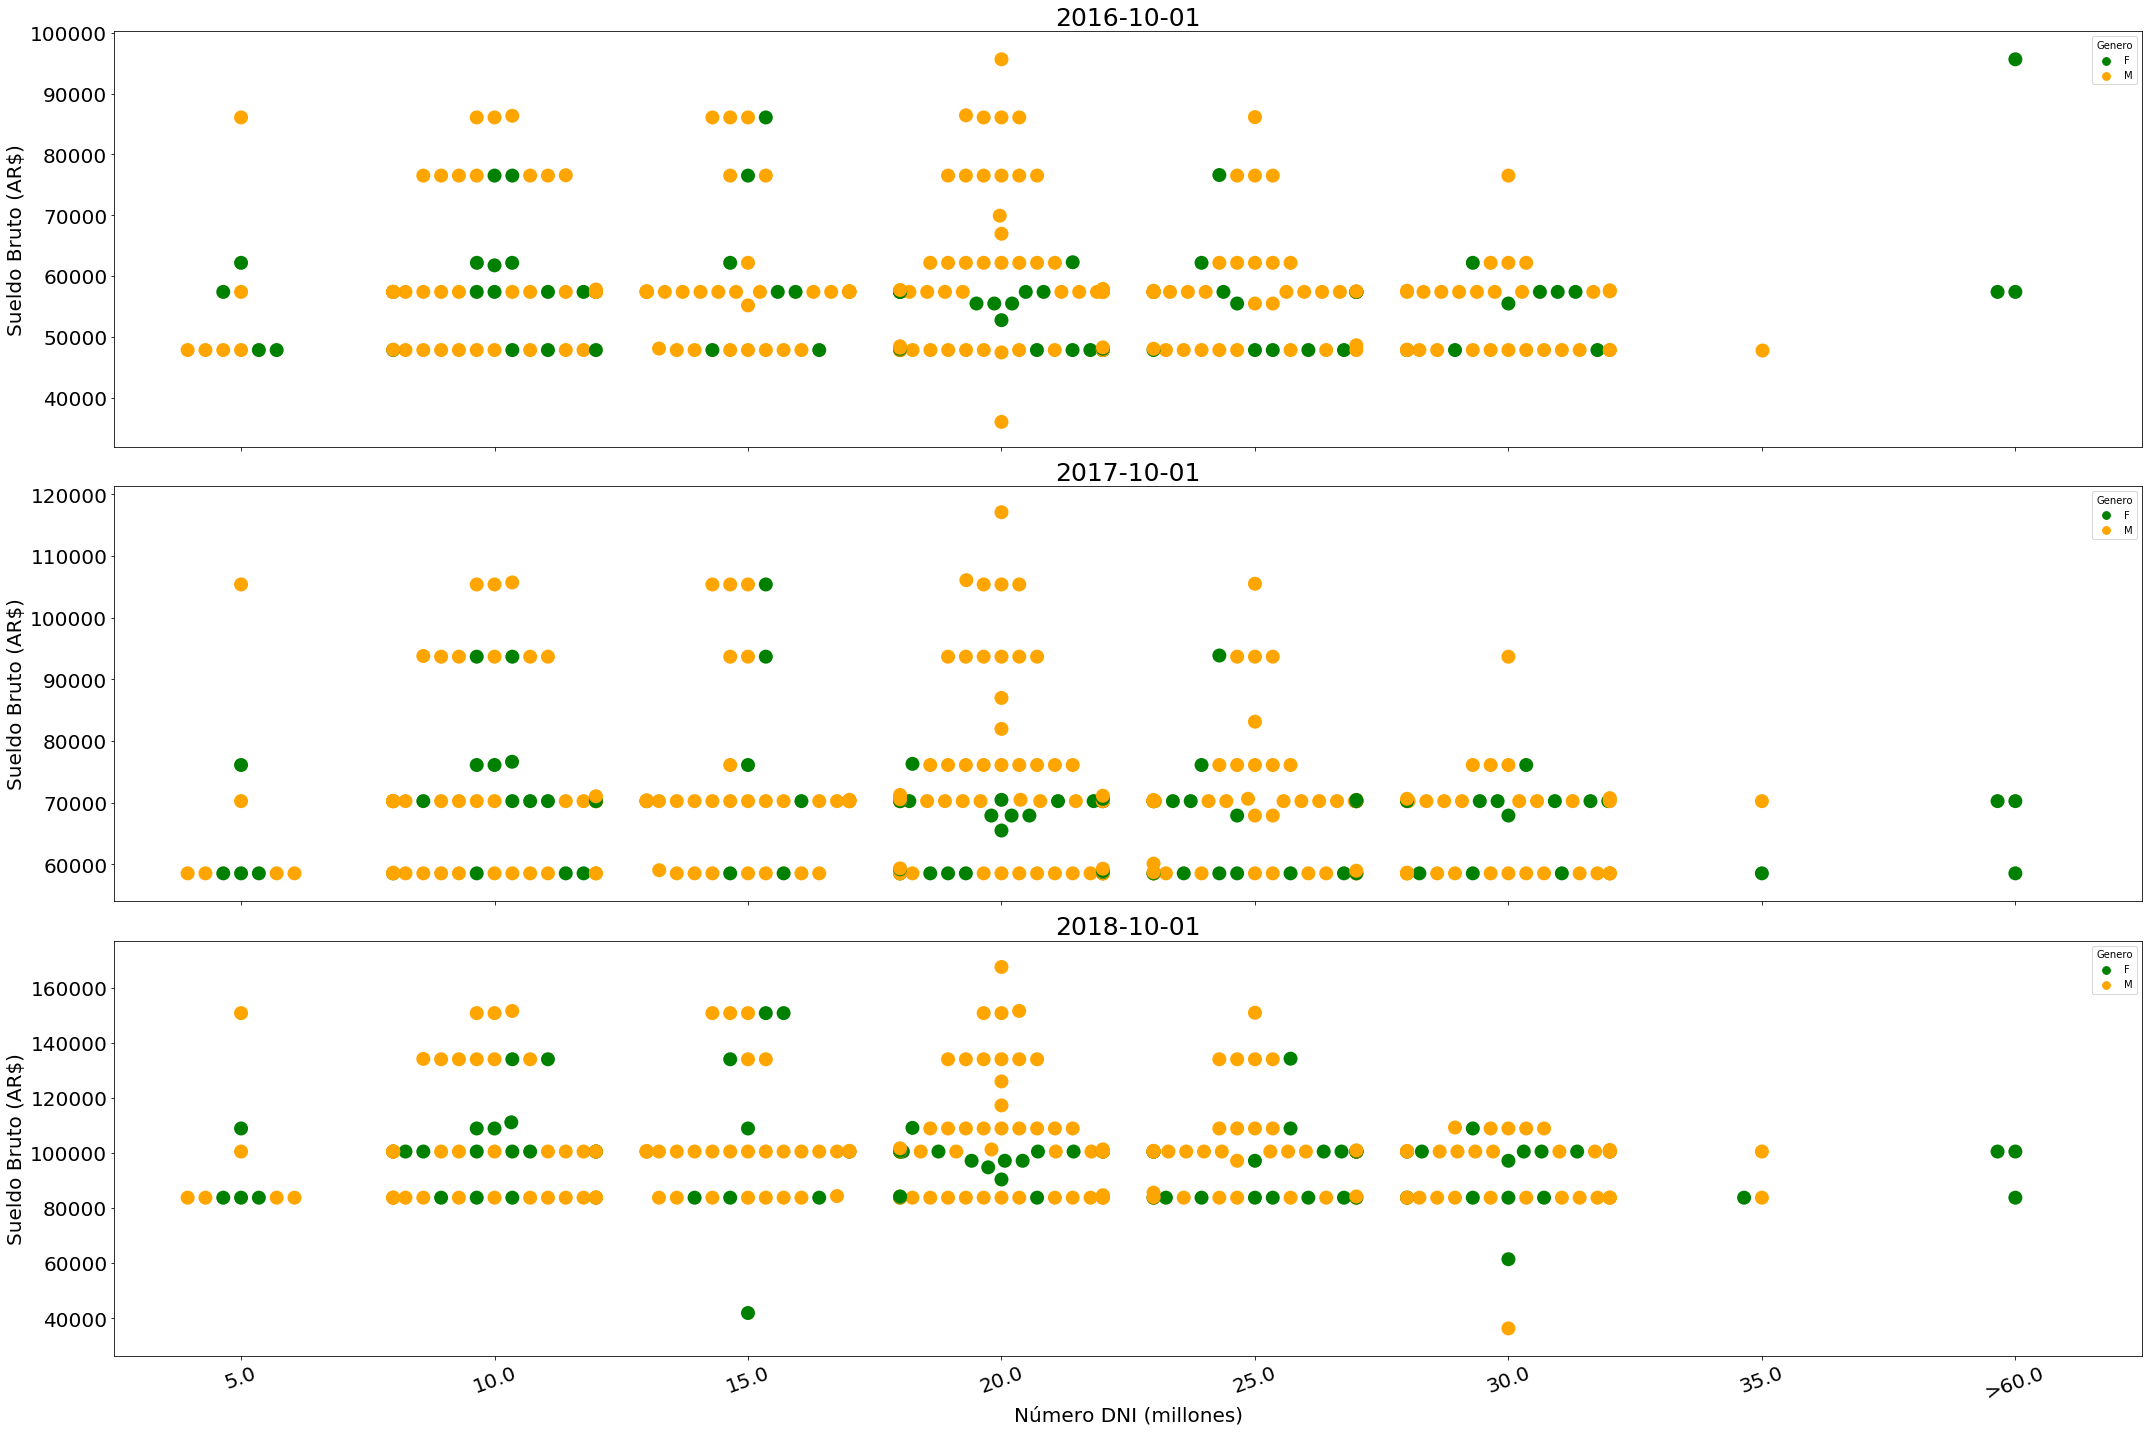

In [31]:
f,ax=plt.subplots(3,1,figsize=(30,20),sharex=True)

for i,time_start in enumerate(['2016-10-01','2017-10-01','2018-10-01']):
    
    pd_temp=pd_cat_time_index[time_start:time_start]
    pd_data=pd_temp
   # sns.violinplot(x='DOC_RNG',y='Sueldo Bruto',hue='Genero', data=pd_data,ax=ax[i],hue_order=['F','M'],palette=my_pal,cut=2,scale='count',scale_hue=True,split=True,inner='quartile')
    sns.swarmplot(x='DOC_RNG',y='Sueldo Bruto',hue='Genero', data=pd_data,ax=ax[i],hue_order=['F','M'],palette=my_pal,size=14)
    ax[i].tick_params(axis='both', which='major', labelsize=20)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Sueldo Bruto (AR$)',fontsize=20)
    ax[i].set_title(time_start,fontsize=25)
    #ax[i].set_ylim([15000,None])
    ymax=ax[i].get_yticks()[-1]
    # Set text
    #set_gender_num(pd_data,ymax,ax[i])

# Update last plot labels
labels = [item.get_text() for item in ax[2].get_xticklabels()]
labels_upd=labels 
for i,lj in enumerate(zip(labels,labels_upd)):
    l,lu=lj
    if l in dict_bnds:
        labels_upd[i]=dict_bnds[l]
ax[2].set_xticklabels(labels_upd,rotation=20);   
ax[2].set_xlabel('Número DNI (millones)',fontsize=20)
plt.tight_layout()

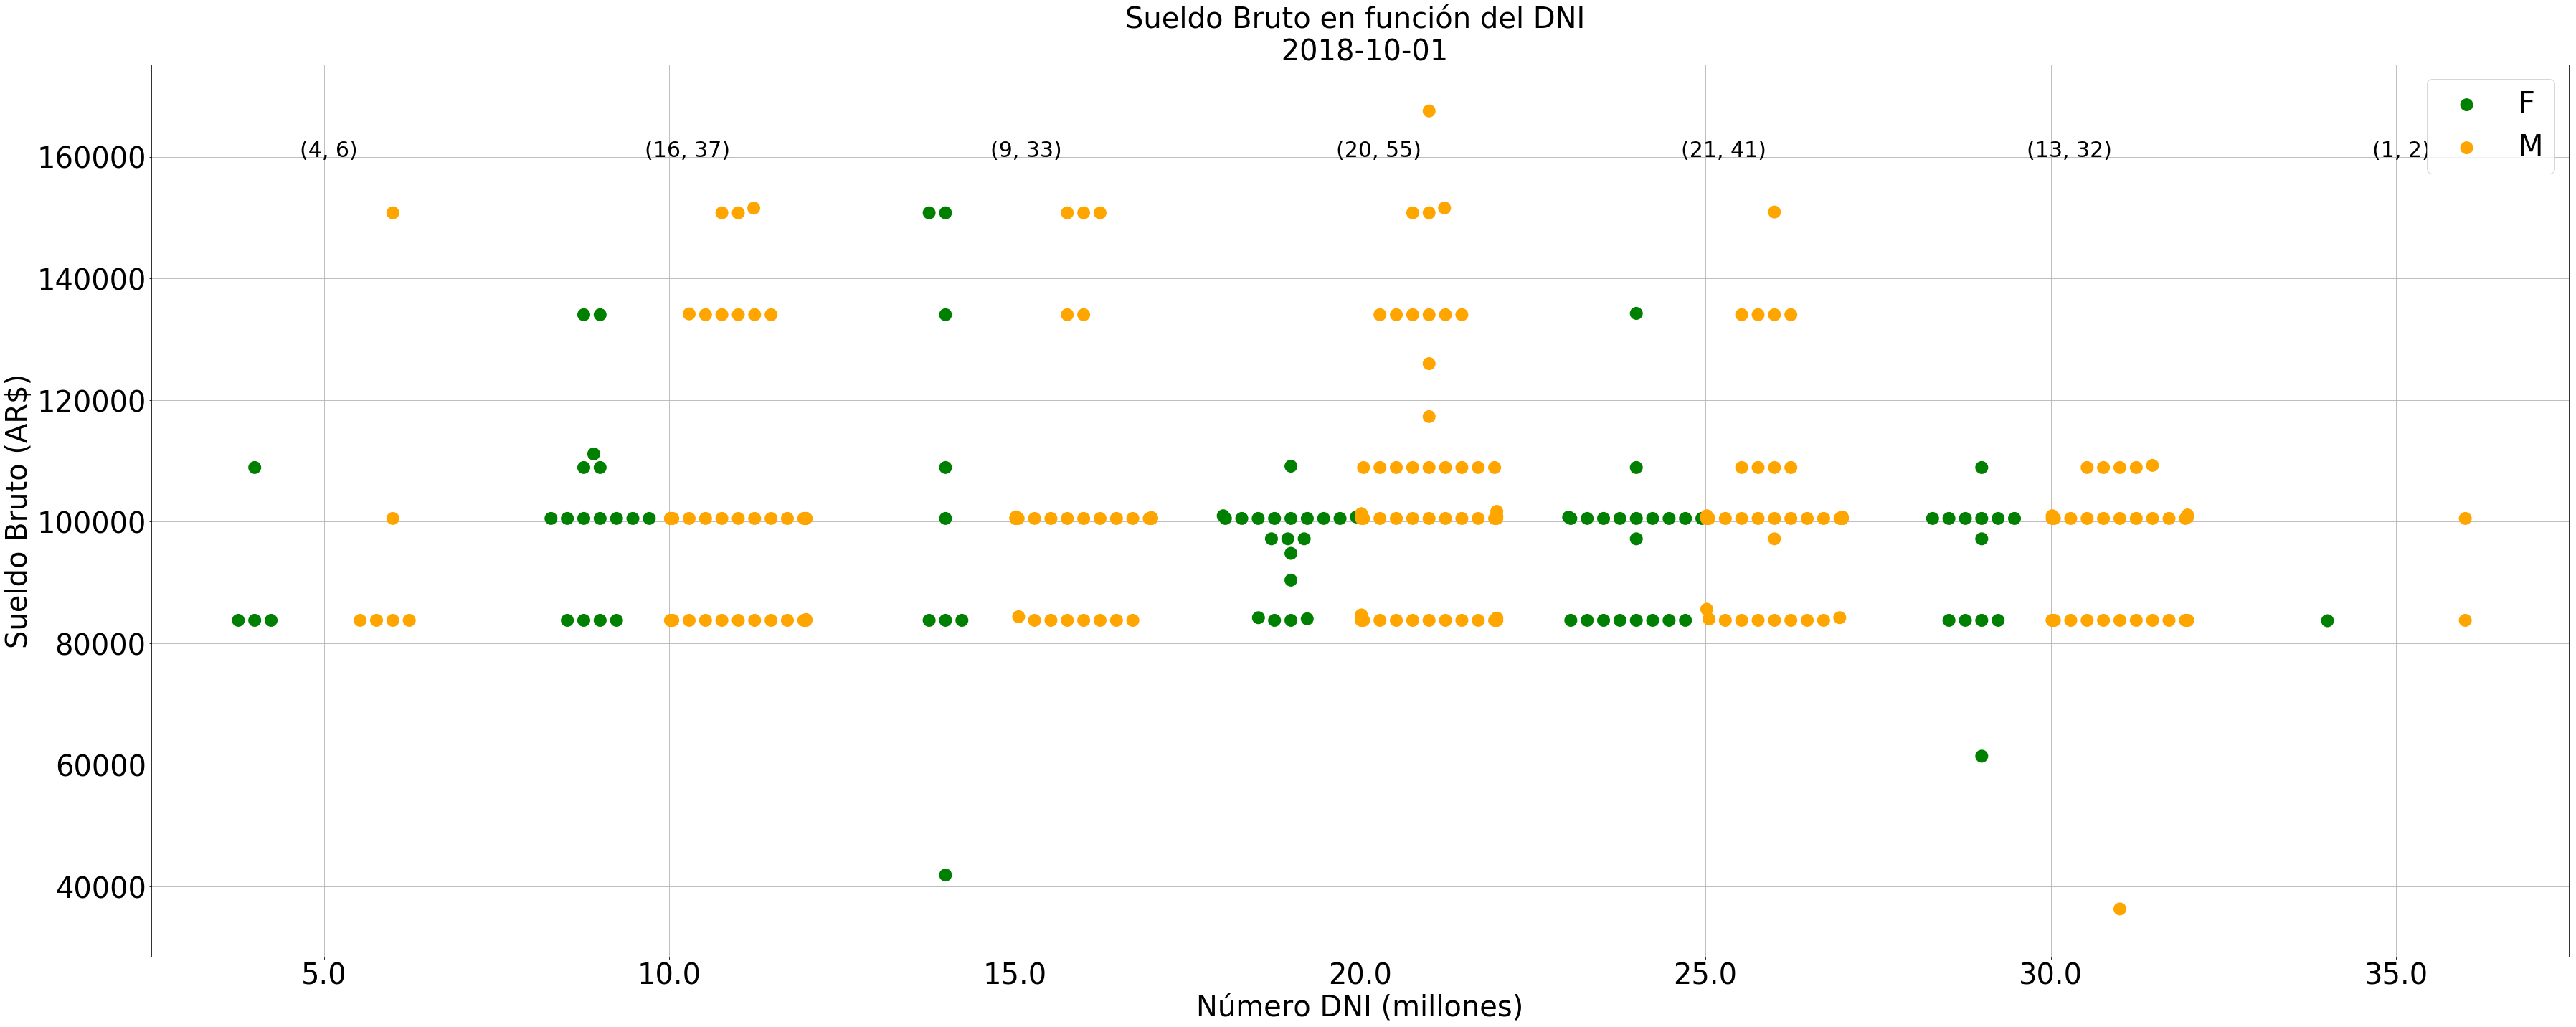

In [32]:
# mejor veamos el ultimo mes
f,ax=plt.subplots(1,1,figsize=(50,20))
time_start='2018-10-01'
pd_temp=pd_cat_time_index[time_start:time_start]
pd_data=pd_temp[pd_temp.DOC_RNG<7]
sns.swarmplot(x='DOC_RNG',y='Sueldo Bruto',hue='Genero', data=pd_data,ax=ax,hue_order=['F','M'],palette=my_pal,size=18,dodge=True)
ax.set_ylabel('Sueldo Bruto (AR$)',fontsize=40)
ax.set_title('Sueldo Bruto en función del DNI \n ' + time_start,fontsize=40)
# Update last plot labels
labels = [item.get_text() for item in ax.get_xticklabels()]
labels_upd=labels 
for i,lj in enumerate(zip(labels,labels_upd)):
    l,lu=lj
    if l in dict_bnds:
        labels_upd[i]=dict_bnds[l]
ax.set_xticklabels(labels_upd);   
ax.set_xlabel('Número DNI (millones)',fontsize=40)
ax.tick_params(axis='both', which='major', labelsize=40)
ax.legend(['F','M'],fontsize=40)
ymax=ax.get_yticks()[-2]
#Set text
set_gender_num(pd_data,ymax,ax,offset=0.07,fontsize=30)
ax.grid(True)
plt.tight_layout()
plt.savefig('img/dni_sueldo_bruto_dist_dni.png')

Cada marca en el eje x, correponde a un rango entonces, por ejemplo, 5 millones implica el rango [5,10) millones, 10 millones implica [10,15) millones, etc
Adicionalmente se pueden observar en la forma (#F,#M), la cantidad de casos por rango.

En general el genero 'F' contribuye en todos los rangos (es decir existe un funcionario F equivalente al menos en Sueldo Bruto a uno o mas Funcionarios M), pero 
llama la atención el correspondiente a 20 millones en el cual esta equivalencia no parece mantenerse (existe una buena cantidad de casos M sin equivalencia para F).